# Top Mass DCTR 1D - $m_{bl\nu}$ + $p_{T, b_\nu}$

This notebook attempts to train and validate a DCTR model paramterized by the top mass only using reconstructed hadronic mass $m_{bl\nu}$ and the transverse momentum of the leptonic b-jet, from which $m_{bl\nu}$ is calculated, $p_{T, b_\nu}$ for each event. $p_{T, b_\nu}$ is included to possibly improve reweighting at detector level.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function
from IPython.display import display, clear_output

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/asuresh/DCTRFitting/TopQuarkFitting/'

In [4]:
# fetch m_T vals from default dataset
train_dataset_0_mT_x4 = np.load(data_dir + 'part_172_5_6j_x4.npy')[:, :1, 5]
train_dataset_0_mT = train_dataset_0_mT_x4

print(np.shape(train_dataset_0_mT))

# fetch lepton b-jet pT vals from default dataset
train_dataset_0_pT_x4 = np.load(data_dir + 'part_172_5_6j_x4.npy')[:, :1, 0]
train_dataset_0_pT = train_dataset_0_pT_x4

print(np.shape(train_dataset_0_mT))

# fetch m_blv vals from default dataset
train_dataset_0_obs_x4 = np.load(data_dir + 'part_172_5_6j_obs_x4.npy')[:, 1:2]
train_dataset_0_obs = train_dataset_0_obs_x4

print(np.shape(train_dataset_0_obs))

# fetch m_T vals from varied dataset
train_dataset_1_mT_x4 = np.load(data_dir + 'part_varmass_6j_x4.npy')[:, :1, 5]
train_dataset_1_mT = train_dataset_1_mT_x4

print(np.shape(train_dataset_1_mT))

# fetch lepton b-jet pT vals from default dataset
train_dataset_1_pT_x4 = np.load(data_dir + 'part_varmass_6j_x4.npy')[:, :1, 0]
train_dataset_1_pT = train_dataset_1_pT_x4

print(np.shape(train_dataset_1_pT))

# fetch m_blv vals from varied dataset
train_dataset_1_obs_x4 = np.load(data_dir +
                                 'part_varmass_6j_obs_x4.npy')[:, 1:2]
train_dataset_1_obs = train_dataset_1_obs_x4  #[:len(train_dataset_0_mjjj)]

print(np.shape(train_dataset_1_obs))

(883443, 1)
(883443, 1)
(883443, 1)
(3362263, 1)
(3362263, 1)
(3362263, 1)


In [5]:
def preprocess(X):
    result = np.copy(X)
    for i in range(result.shape[1]):
        result[:,i] = (result[:,i] - np.mean(result[:,i]))/np.std(result[:,i])
    return result

def preprocess(X):
    result = np.copy(X)/1000.
    return result

In [6]:
def preprocess_mT(mT):
    
    # mT from uniform distribution
    mT_min = 170.
    mT_max = 180.
    
    mT_mean = (mT_max + mT_min)/2
    mT_std = ((mT_max - mT_min)**2/12.)**0.5
    result = (mT -mT_mean)/mT_std
    
    return result

def preprocess_mT(mT):
    
    return (mT/1000.)

In [7]:
X0 = np.concatenate((train_dataset_0_obs, train_dataset_0_pT ,train_dataset_0_mT), axis=1)
X1 = np.concatenate((train_dataset_1_obs, train_dataset_1_pT, train_dataset_1_mT), axis=1)

print(np.shape(X0))
print(np.shape(X1))

print(len(X1) / len(X0))  # different sizes if != 1

(883443, 3)
(3362263, 3)
3.805862970219924


In [8]:
Y0 = np.zeros_like(X0[:, 0])
Y1 = np.ones_like(X1[:, 0])

In [9]:
X = np.concatenate((X0, X1), axis=0)

mask = np.ones((len(X)))
for i in range(X.shape[1]):
    mask *= np.logical_not(np.isnan(X[:,i]))

X = np.delete(X, np.where(mask == False), 0)

Y = np.concatenate((Y0, Y1), axis=0)
Y = to_categorical(Y, num_classes=2)
Y = np.delete(Y, np.where(mask == False), 0)

In [10]:
X = preprocess(X)

In [11]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [12]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(3396564, 3)
(3396564, 2)
(849141, 3)
(849141, 2)


## Build Model

In [13]:
# Get predicted probabilities
def reweight(default_dataset, mT):
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = (default_dataset.shape[0],1)) * mT
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((default_dataset, concat_input_and_params), axis=-1)

    f = dctr(model_inputs)
    
    # liklihood_ratio = len(X0)/len(X1)
    
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

In [14]:
test_dataset_0_obs = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1:2]
test_dataset_0_pT = np.load(data_dir + 'part_172_5_6j.npy')[:, :1, 0]
test_dataset_0 = np.concatenate((test_dataset_0_obs, test_dataset_0_pT), axis = 1)

test_dataset_1_obs = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1:2]
test_dataset_1_pT = np.load(data_dir + 'part_175_0_6j.npy')[:, :1, 0]
test_dataset_1 = np.concatenate((test_dataset_1_obs, test_dataset_1_pT), axis = 1)

print(np.shape(test_dataset_0))
print(np.shape(test_dataset_1))

(221723, 2)
(224595, 2)


In [15]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

In [16]:
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

In [17]:
def plt_hist_to_cv(plt_histogram_output):
    counts, bin_edges, _ = plt_histogram_output
    return counts.ravel().astype('float32')

Iteration:  1







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3396564 samples, validate on 849141 samples
Epoch 1/1000





 - 16s - loss: 0.5125 - acc: 0.7917 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 2/1000
 - 15s - loss: 0.5115 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 3/1000
 - 16s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7921
Epoch 4/1000
 - 21s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 5/1000
 - 21s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 6/1000
 - 21s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5110 - val_acc: 0.7921
Epoch 7/1000
 - 21s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7921
Epoch 8/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 9/1000
 - 19s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5110 - val_acc: 0.7921
Epoch 10/1000
 - 19s - loss: 0.5113 - acc: 0.7919 

Epoch 56/1000
 - 21s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 57/1000
 - 19s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 58/1000
 - 19s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 59/1000
 - 20s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 60/1000
 - 21s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 61/1000
 - 21s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 62/1000
 - 21s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 63/1000
 - 21s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7921
Epoch 64/1000
 - 19s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5109 - val_acc: 0.7921
Epoch 65/1000
 - 19s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 66/1000
 - 20s - loss: 0.5111 - acc: 0.7919 - val_loss: 0.5108 - val_acc: 0.7921
Epoch 67/1000
 - 21s - loss: 0.5111 - acc: 

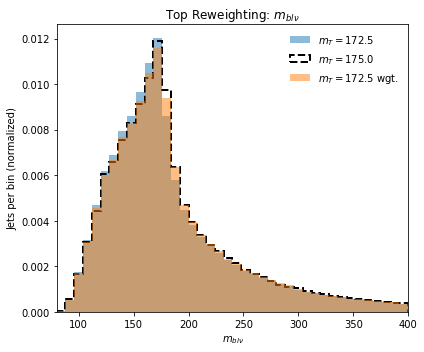

0.999576393497588
Success. Saving weights.
(8,)
Iteration:  2
Train on 3396564 samples, validate on 849141 samples
Epoch 1/1000
 - 16s - loss: 0.5121 - acc: 0.7920 - val_loss: 0.5123 - val_acc: 0.7915
Epoch 2/1000
 - 16s - loss: 0.5113 - acc: 0.7920 - val_loss: 0.5119 - val_acc: 0.7915
Epoch 3/1000
 - 16s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5119 - val_acc: 0.7915
Epoch 4/1000
 - 16s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7915
Epoch 5/1000
 - 16s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7915
Epoch 6/1000
 - 16s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7915
Epoch 7/1000
 - 16s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7915
Epoch 8/1000
 - 16s - loss: 0.5111 - acc: 0.7920 - val_loss: 0.5117 - val_acc: 0.7915
Epoch 9/1000
 - 16s - loss: 0.5111 - acc: 0.7920 - val_loss: 0.5119 - val_acc: 0.7915
Epoch 10/1000
 - 16s - loss: 0.5111 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7915
Epoch 11/1000
 - 16s - l

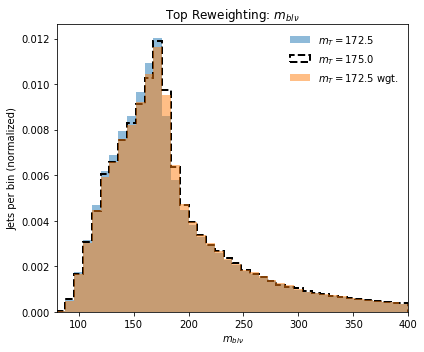

0.9997252537396993
Success. Saving weights.
(8,)
Iteration:  3
Train on 3396564 samples, validate on 849141 samples
Epoch 1/1000
 - 20s - loss: 0.5124 - acc: 0.7918 - val_loss: 0.5115 - val_acc: 0.7918
Epoch 2/1000
 - 19s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5115 - val_acc: 0.7918
Epoch 3/1000
 - 19s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5115 - val_acc: 0.7918
Epoch 4/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5118 - val_acc: 0.7918
Epoch 5/1000
 - 21s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5116 - val_acc: 0.7917
Epoch 6/1000
 - 21s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5116 - val_acc: 0.7918
Epoch 7/1000
 - 21s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5114 - val_acc: 0.7918
Epoch 8/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5115 - val_acc: 0.7918
Epoch 9/1000
 - 19s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5114 - val_acc: 0.7918
Epoch 10/1000
 - 19s - loss: 0.5112 - acc: 0.7919 - val_loss: 0.5114 - val_acc: 0.7918
Epoch 11/1000
 - 20s - 

Epoch 94/1000
 - 21s - loss: 0.5110 - acc: 0.7919 - val_loss: 0.5111 - val_acc: 0.7918
Epoch 95/1000
 - 21s - loss: 0.5110 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7918


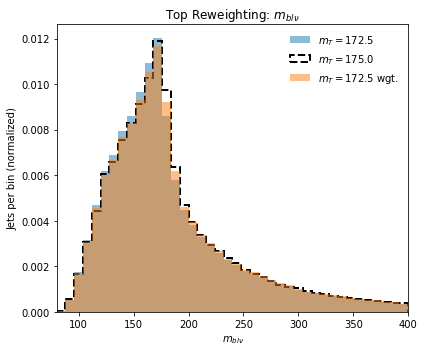

0.999328679624989
Success. Saving weights.
(8,)
Iteration:  4
Train on 3396564 samples, validate on 849141 samples
Epoch 1/1000
 - 21s - loss: 0.5125 - acc: 0.7918 - val_loss: 0.5113 - val_acc: 0.7919
Epoch 2/1000
 - 19s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5113 - val_acc: 0.7919
Epoch 3/1000
 - 19s - loss: 0.5114 - acc: 0.7919 - val_loss: 0.5115 - val_acc: 0.7919
Epoch 4/1000
 - 19s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5113 - val_acc: 0.7919
Epoch 5/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5114 - val_acc: 0.7919
Epoch 6/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5113 - val_acc: 0.7919
Epoch 7/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5113 - val_acc: 0.7919
Epoch 8/1000
 - 20s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7919
Epoch 9/1000
 - 19s - loss: 0.5113 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7919
Epoch 10/1000
 - 19s - loss: 0.5112 - acc: 0.7919 - val_loss: 0.5112 - val_acc: 0.7919
Epoch 11/1000
 - 19s - l

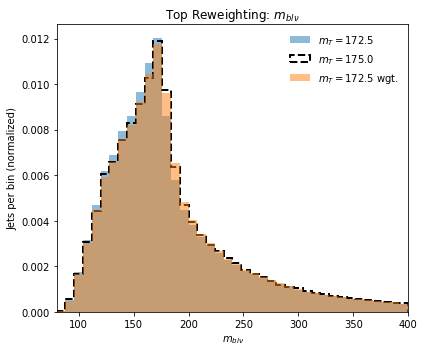

0.9997710766025133
Success. Saving weights.
(8,)
Iteration:  5
Train on 3396564 samples, validate on 849141 samples
Epoch 1/1000
 - 20s - loss: 0.5124 - acc: 0.7920 - val_loss: 0.5120 - val_acc: 0.7916
Epoch 2/1000
 - 19s - loss: 0.5113 - acc: 0.7920 - val_loss: 0.5123 - val_acc: 0.7916
Epoch 3/1000
 - 19s - loss: 0.5113 - acc: 0.7920 - val_loss: 0.5117 - val_acc: 0.7916
Epoch 4/1000
 - 21s - loss: 0.5113 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7916
Epoch 5/1000
 - 21s - loss: 0.5113 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7916
Epoch 6/1000
 - 21s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5117 - val_acc: 0.7916
Epoch 7/1000
 - 21s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5117 - val_acc: 0.7916
Epoch 8/1000
 - 19s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5118 - val_acc: 0.7916
Epoch 9/1000
 - 19s - loss: 0.5112 - acc: 0.7920 - val_loss: 0.5117 - val_acc: 0.7916
Epoch 10/1000
 - 18s - loss: 0.5111 - acc: 0.7920 - val_loss: 0.5116 - val_acc: 0.7916
Epoch 11/1000
 - 22s - 

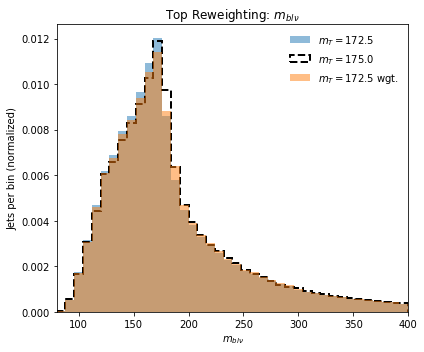

0.9983366958244205


In [18]:
iterations = 5

dctr_weights = []
earlystopping = EarlyStopping(patience=15, restore_best_weights=True)

for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

    K.clear_session()
    inputs = Input((3, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])

    history = dctr.fit(X_train,
                       Y_train,
                       epochs=1000,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=2,
                       callbacks=[earlystopping])

    weights_1 = reweight(default_dataset=tf.convert_to_tensor(
        preprocess(test_dataset_0), dtype=tf.float32),
                         mT=preprocess_mT(175.))
    weights_1 = K.eval(weights_1)

    plt.figure(figsize=(6, 5))
    plt.title(r"Top Reweighting: $m_{bl\nu}$")
    bins = np.linspace(80, 400, 41)
    hist0_mlbv = plt.hist(test_dataset_0_obs,
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mlbv = plt.hist(test_dataset_1_obs,
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mlbv = plt.hist(test_dataset_0_obs,
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights_1,
                          **plot_style_1)

    plt.xlabel(r'$m_{bl\nu}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()

    correlation = cv2.compareHist(plt_hist_to_cv(hist1_mlbv),
                                  plt_hist_to_cv(hist2_mlbv),
                                  method=0)
    print(correlation)

    if correlation > 0.999:
        print("Success. Saving weights.")
        trial_weights = dctr.get_weights()
        print(np.shape(trial_weights))
        dctr_weights += [trial_weights]

## Train DCTR Model

## Correlation over original sized datasets

In [19]:
test_dataset_0_obs = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1:2]
test_dataset_0_pT = np.load(data_dir + 'part_172_5_6j.npy')[:, :1, 0]
test_dataset_0 = np.concatenate((test_dataset_0_obs, test_dataset_0_pT), axis = 1)

test_dataset_1_obs = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1:2]
test_dataset_1_pT = np.load(data_dir + 'part_175_0_6j.npy')[:, :1, 0]
test_dataset_1 = np.concatenate((test_dataset_1_obs, test_dataset_1_pT), axis = 1)

test_dataset_0_obs_det = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,1:2]
test_dataset_0_pT_det = np.load(data_dir + 'det_172_5_6j.npy')[:, :1, 0]
test_dataset_0_det = np.concatenate((test_dataset_0_obs_det, test_dataset_0_pT_det), axis = 1)

test_dataset_1_obs_det = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,1:2]
test_dataset_1_pT_det = np.load(data_dir + 'det_175_0_6j.npy')[:, :1, 0]
test_dataset_1_det = np.concatenate((test_dataset_1_obs_det, test_dataset_1_pT_det), axis = 1)

Weight Iteration:  0
theta:  170.0


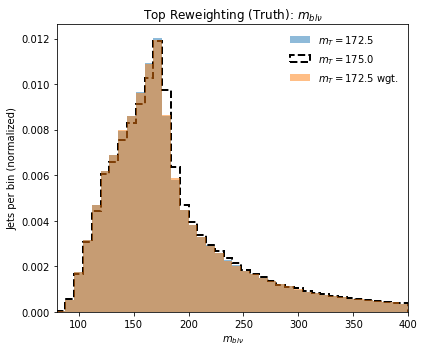

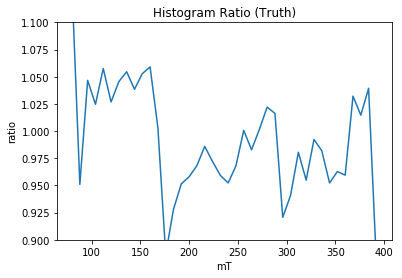

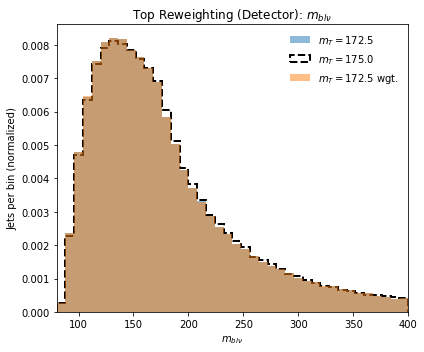

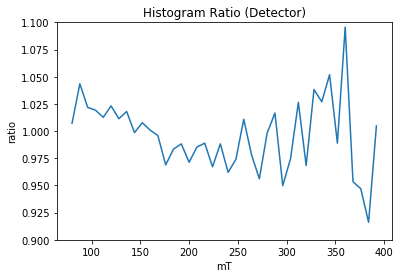

Truth Cor  0.9969037780530345
Det Cor  0.9996953650240378
theta:  170.5


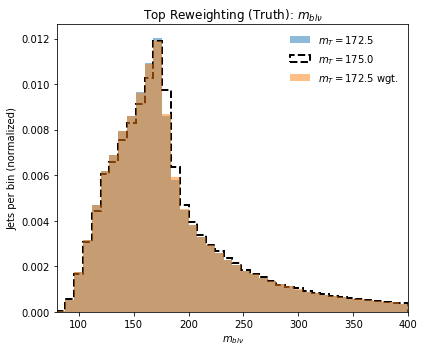

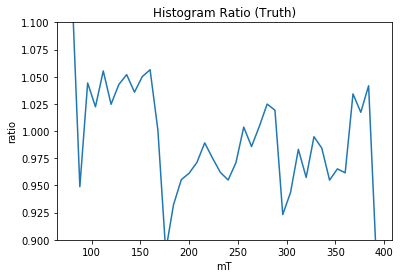

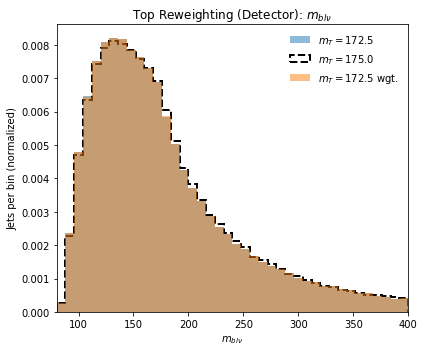

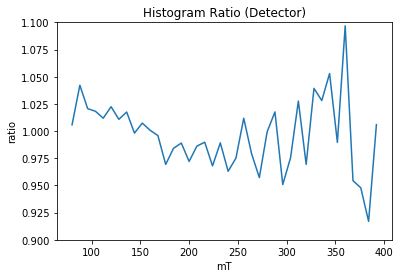

Truth Cor  0.997129477222675
Det Cor  0.9997115077327132
theta:  171.0


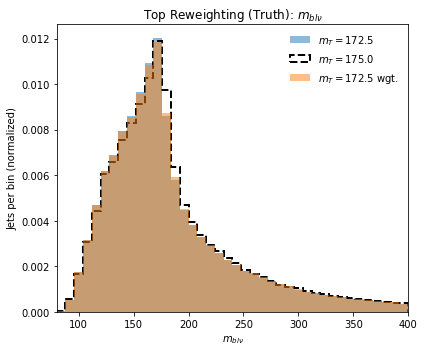

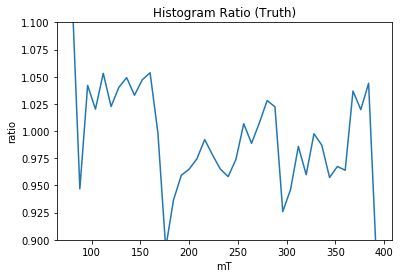

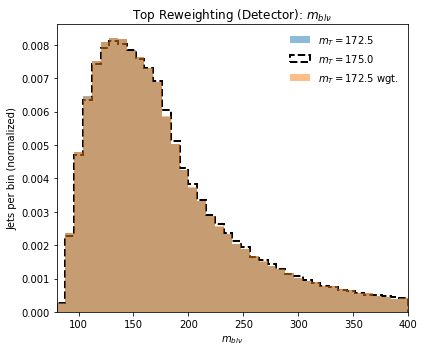

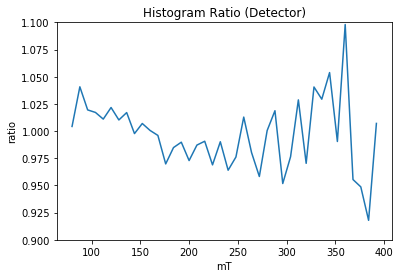

Truth Cor  0.99735383889699
Det Cor  0.9997274591314546
theta:  171.5


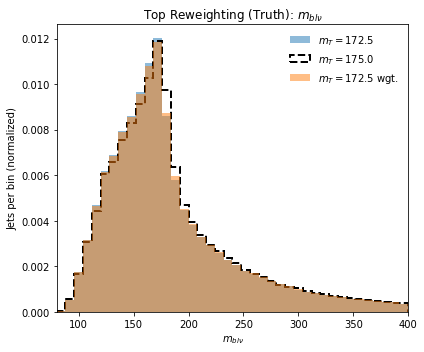

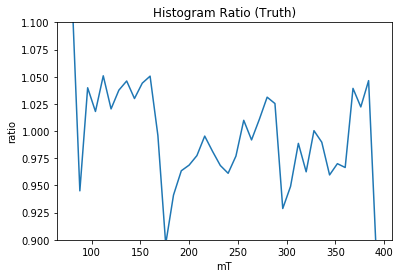

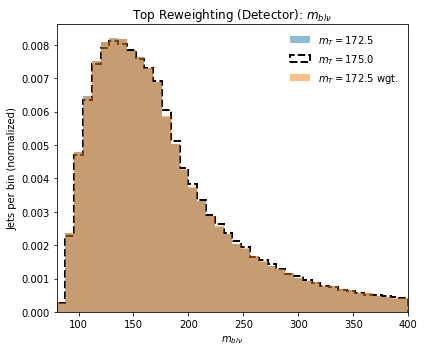

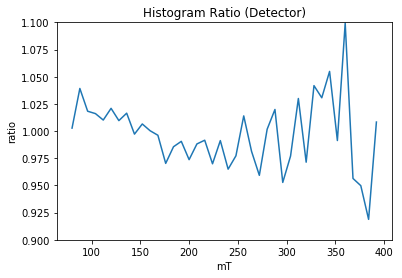

Truth Cor  0.997592591847163
Det Cor  0.9997434996586438
theta:  172.0


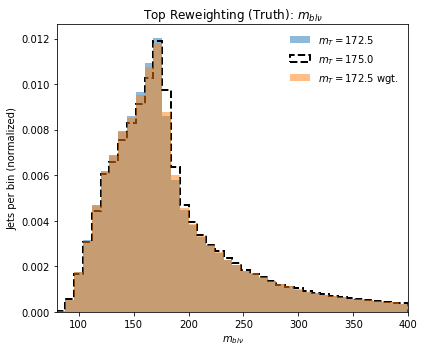

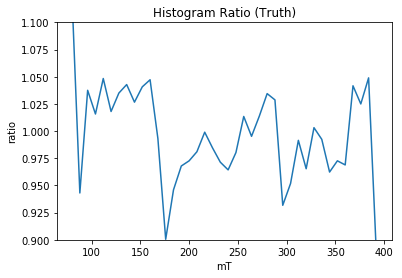

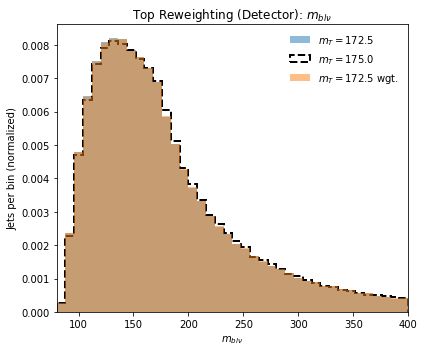

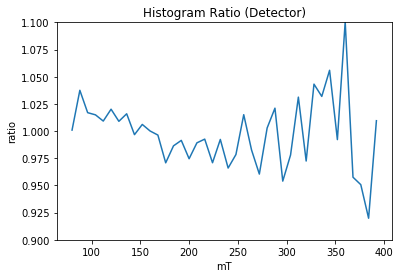

Truth Cor  0.9978463306410466
Det Cor  0.9997597811254881
theta:  172.5


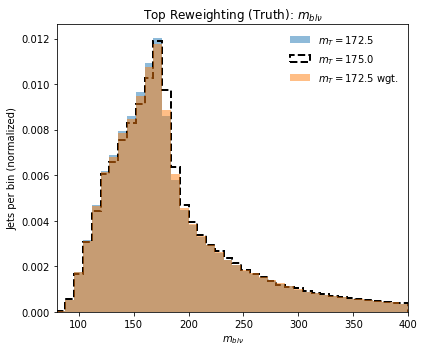

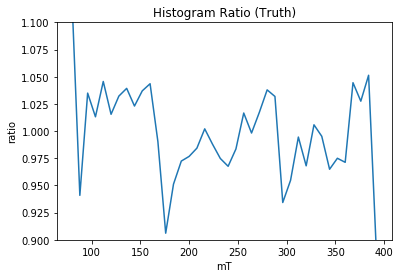

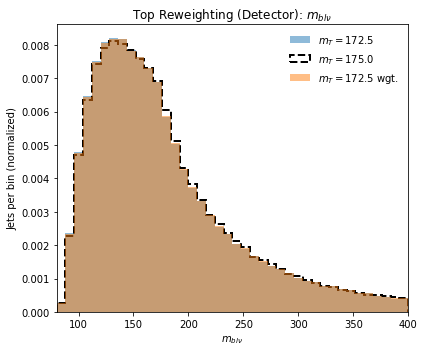

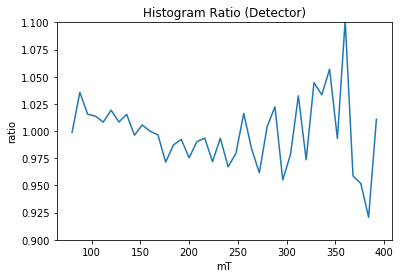

Truth Cor  0.998121031132213
Det Cor  0.9997764300406213
theta:  173.0


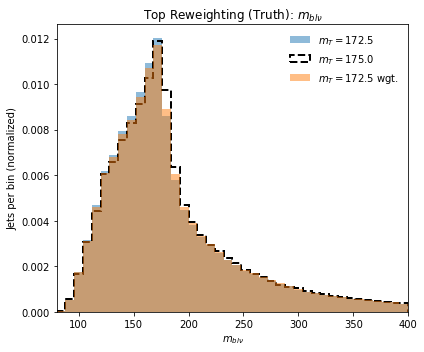

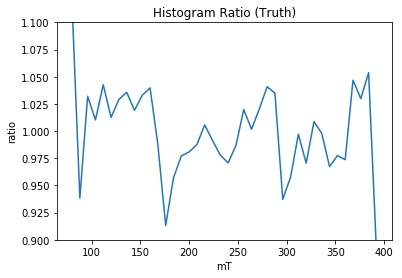

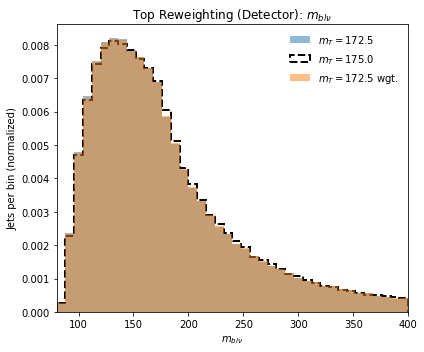

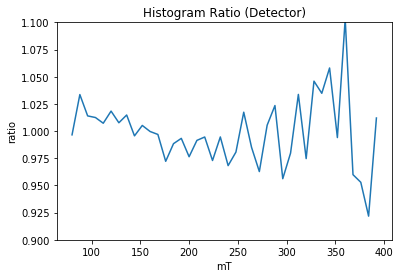

Truth Cor  0.9984155659784066
Det Cor  0.999793499976919
theta:  173.5


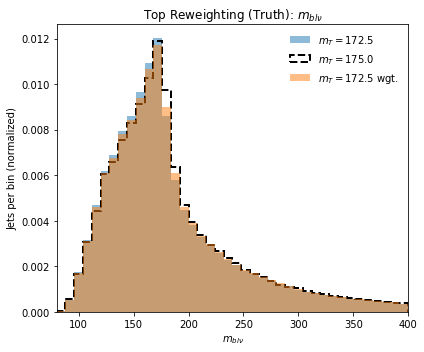

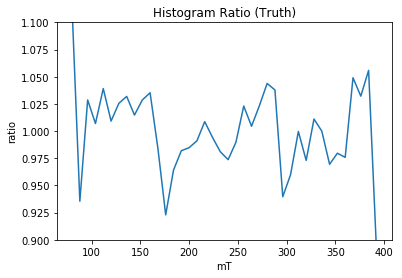

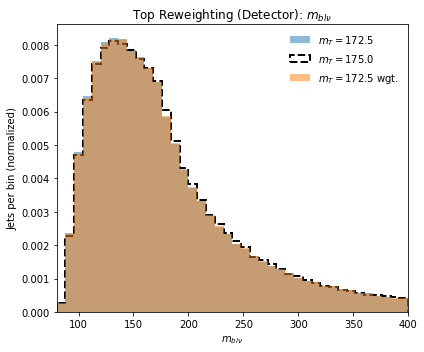

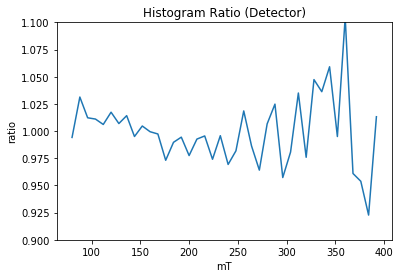

Truth Cor  0.9987415596927424
Det Cor  0.9998115334301351
theta:  174.0


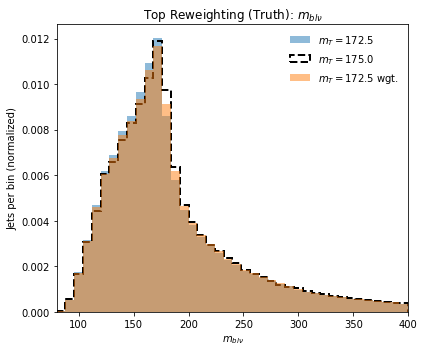

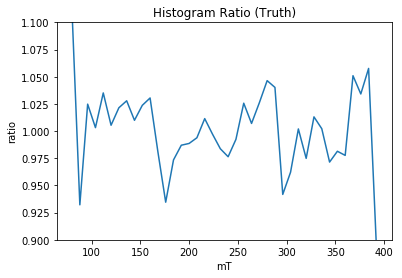

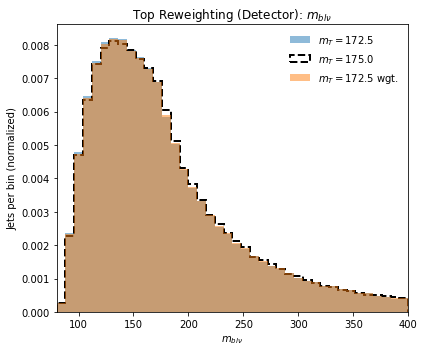

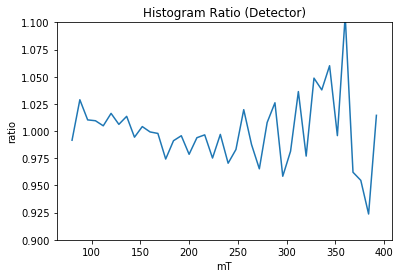

Truth Cor  0.9990674042620727
Det Cor  0.9998298620000611
theta:  174.5


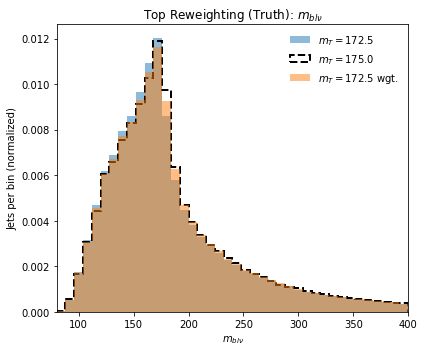

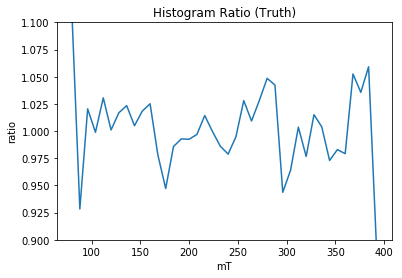

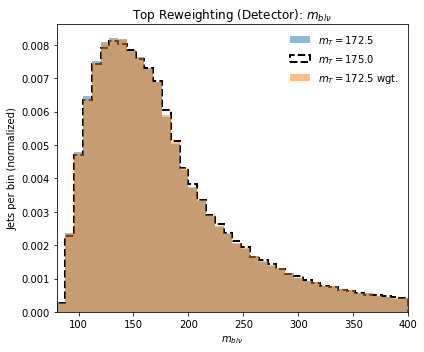

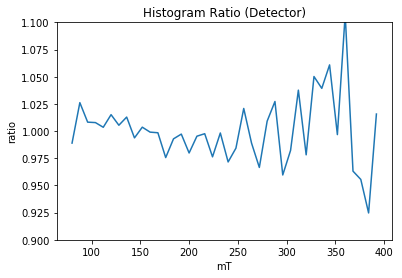

Truth Cor  0.9993552778541736
Det Cor  0.999848231919443
theta:  175.0


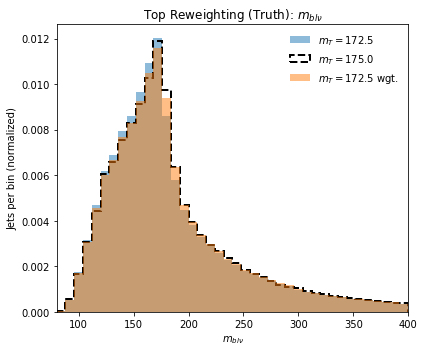

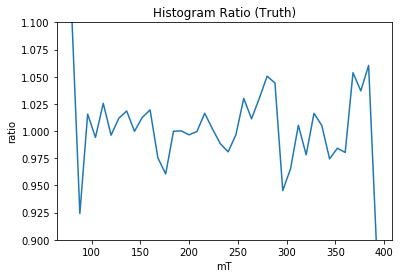

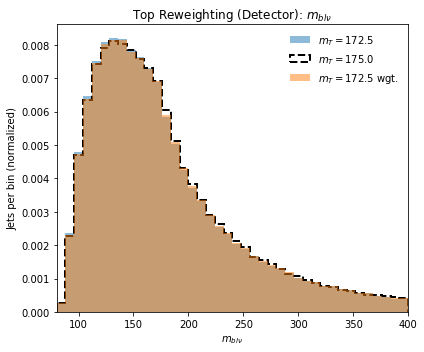

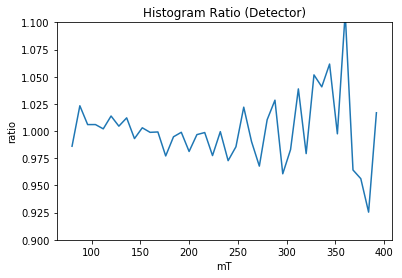

Truth Cor  0.999576393497588
Det Cor  0.9998656384863442
theta:  175.5


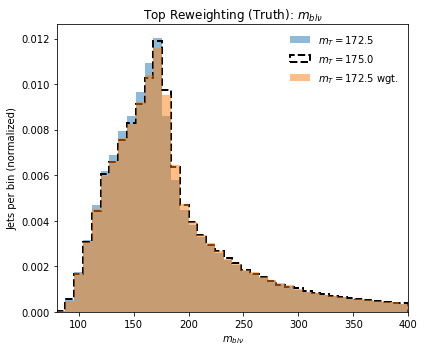

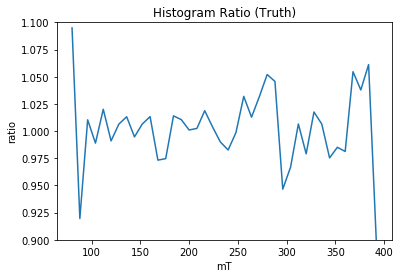

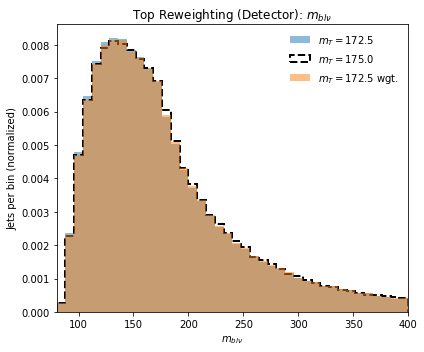

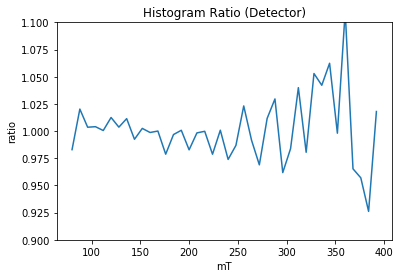

Truth Cor  0.9997115473389987
Det Cor  0.9998813047455939
theta:  176.0


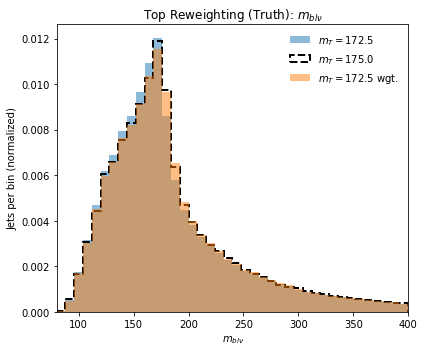

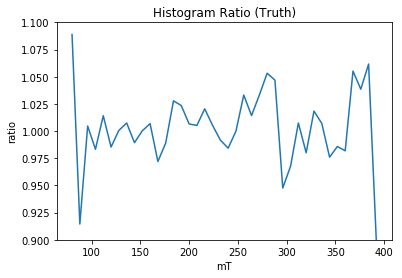

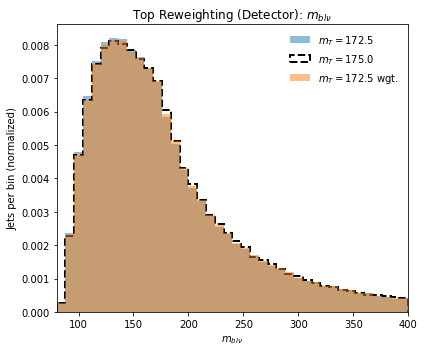

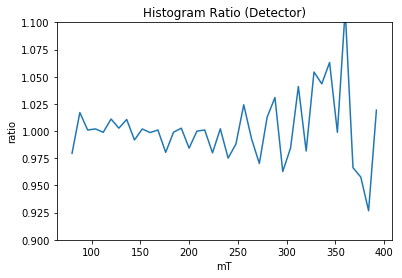

Truth Cor  0.9997445812626011
Det Cor  0.9998943575296194
theta:  176.5


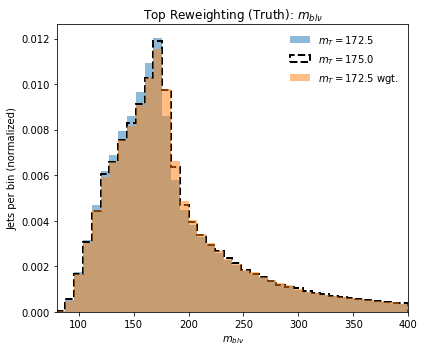

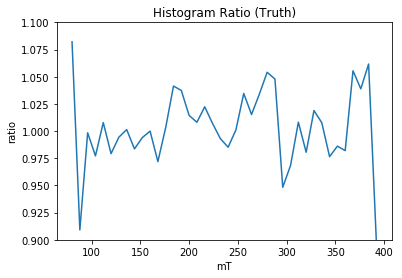

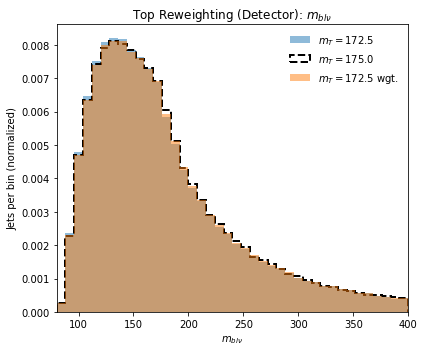

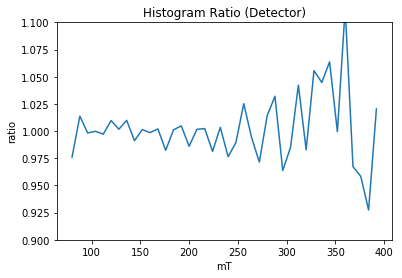

Truth Cor  0.9996673799849415
Det Cor  0.9999043162273755
theta:  177.0


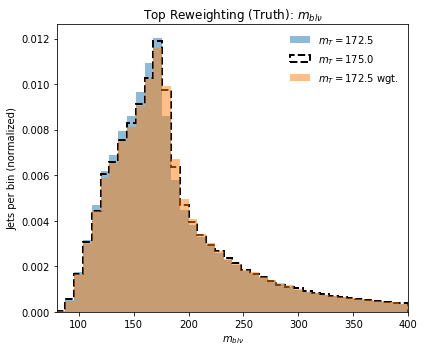

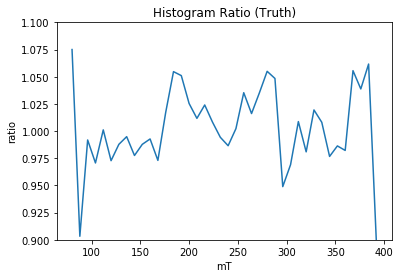

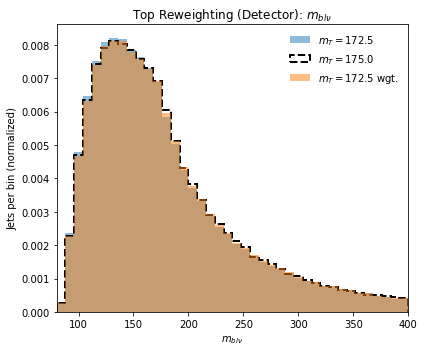

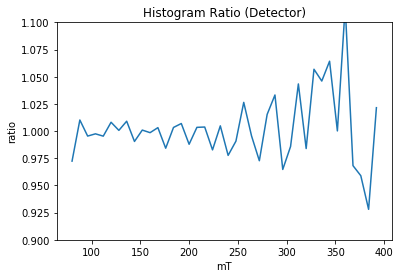

Truth Cor  0.9994767475668901
Det Cor  0.999910229901188
theta:  177.5


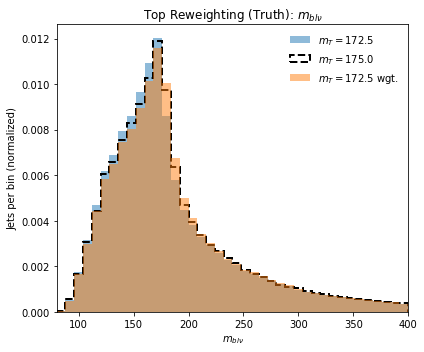

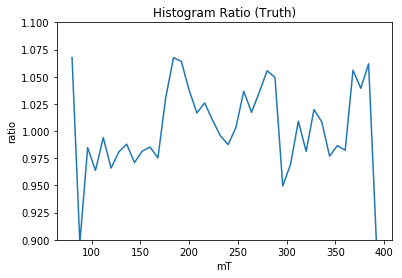

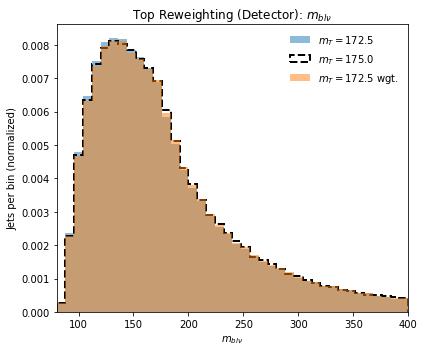

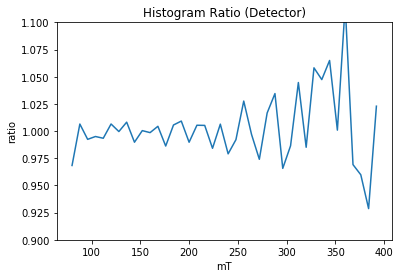

Truth Cor  0.999169741826017
Det Cor  0.9999116805672009
theta:  178.0


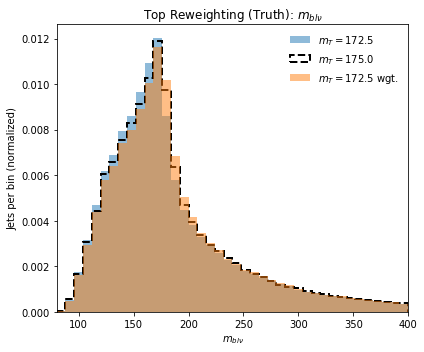

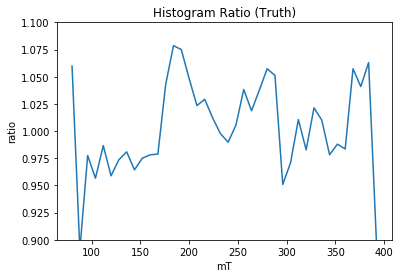

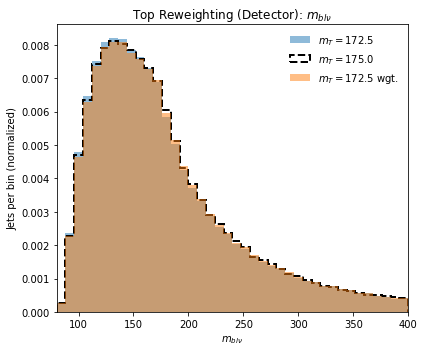

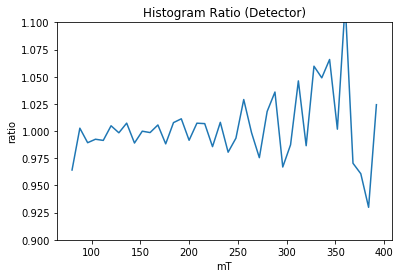

Truth Cor  0.9987754306700682
Det Cor  0.9999081135685192
theta:  178.5


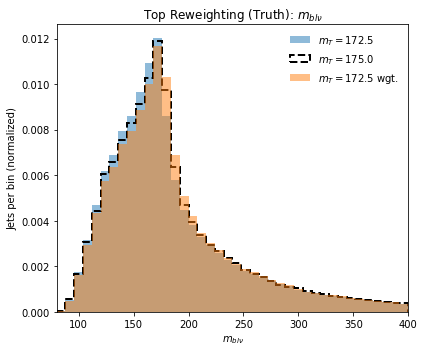

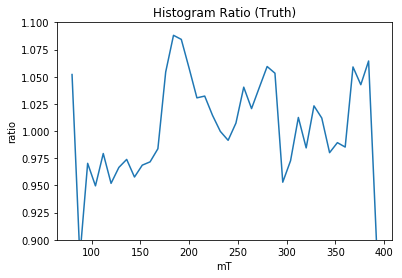

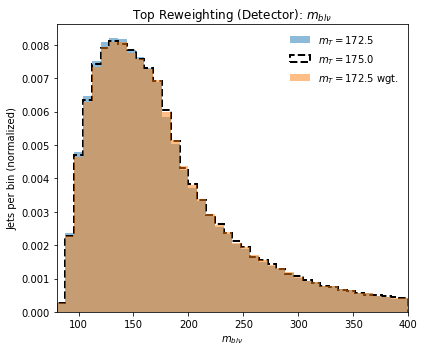

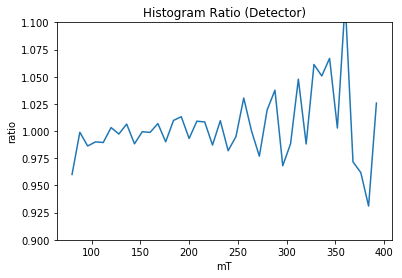

Truth Cor  0.9983177714710284
Det Cor  0.9998997051386939
theta:  179.0


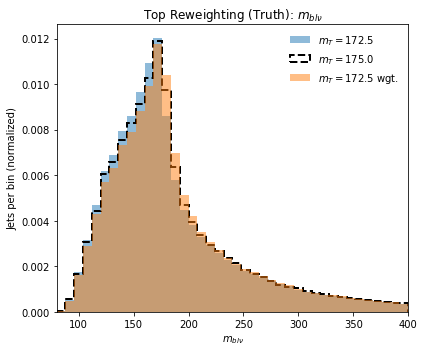

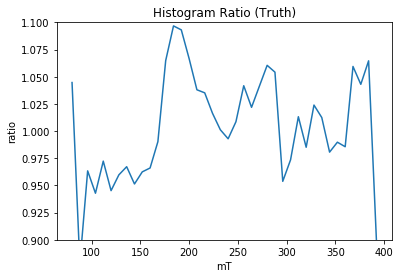

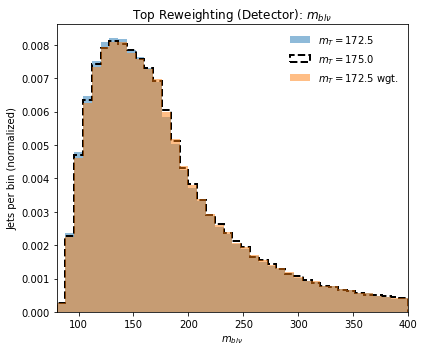

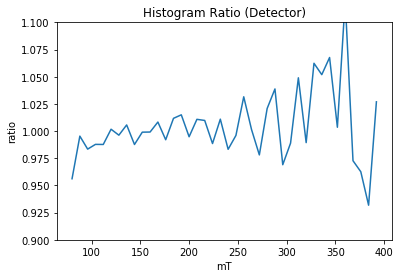

Truth Cor  0.9977984089390154
Det Cor  0.9998873416856046
theta:  179.5


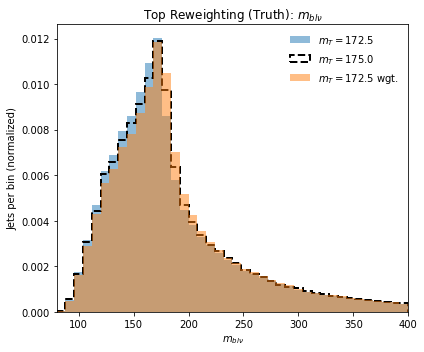

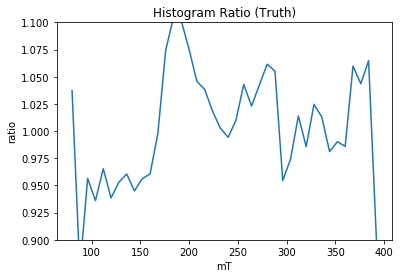

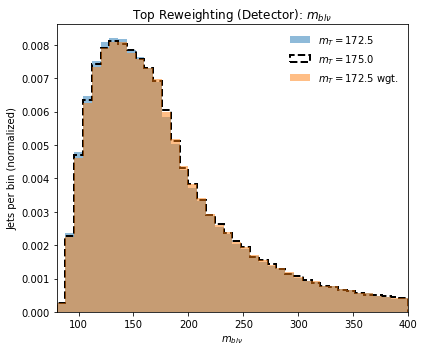

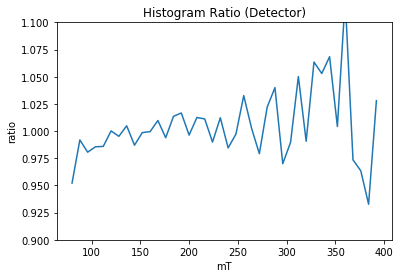

Truth Cor  0.9972101793436329
Det Cor  0.9998708098656666
theta:  180.0


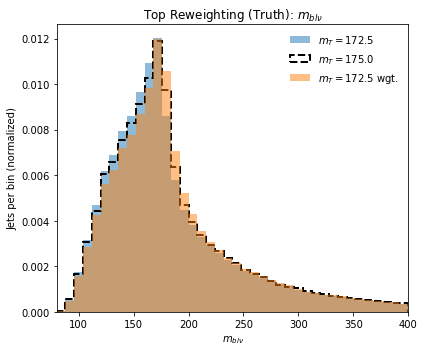

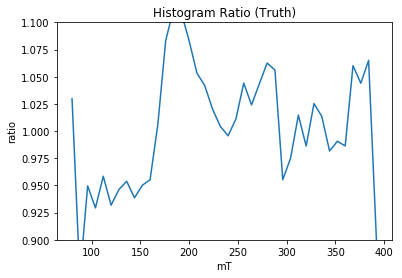

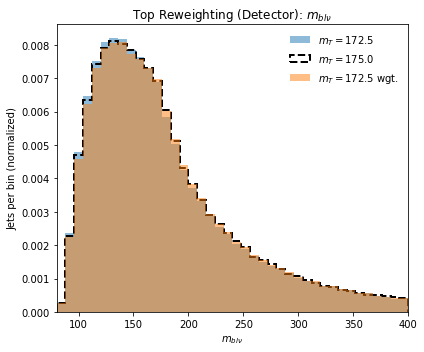

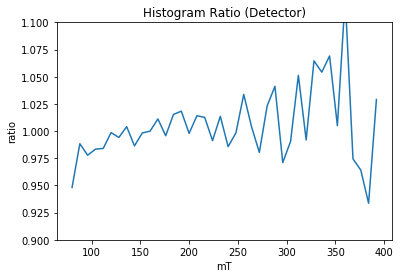

Truth Cor  0.9965507431538639
Det Cor  0.9998501637441315


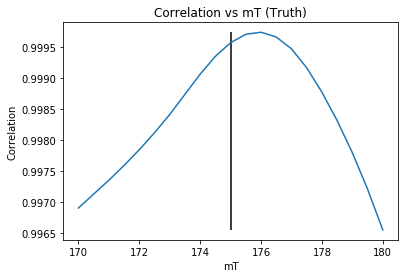

176.0


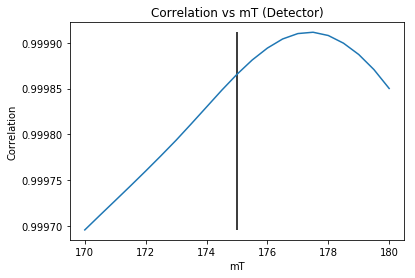

177.5
Weight Iteration:  1
theta:  170.0


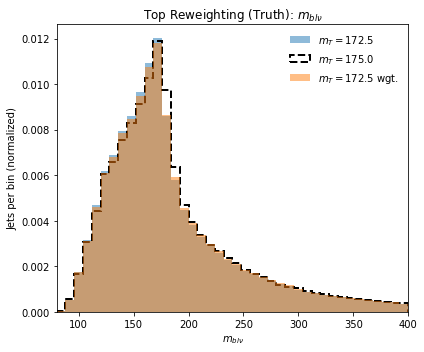

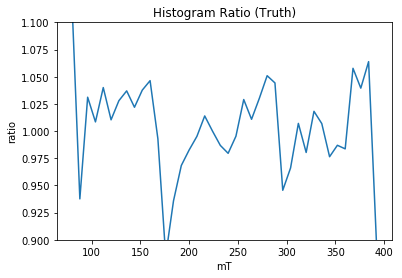

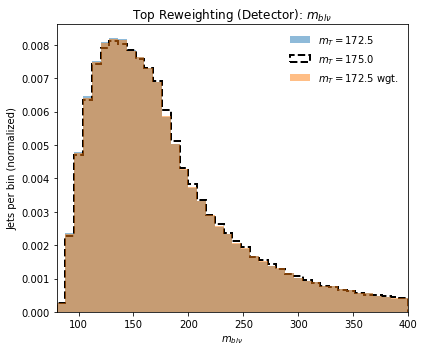

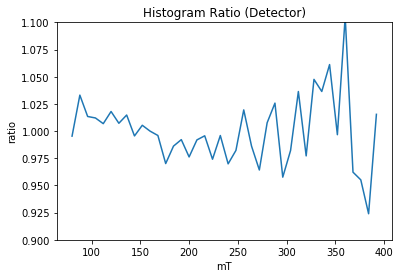

Truth Cor  0.9975306974346028
Det Cor  0.9997847965931954
theta:  170.5


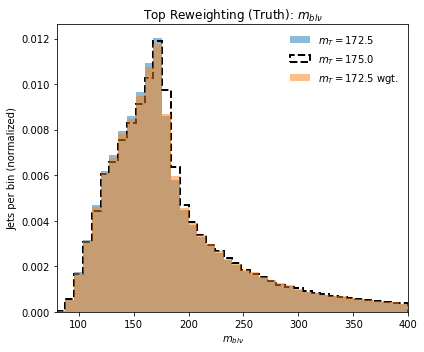

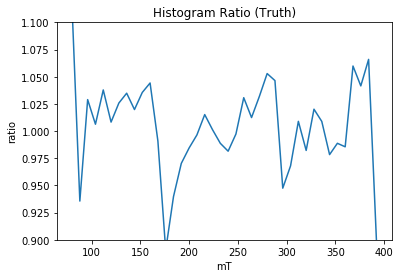

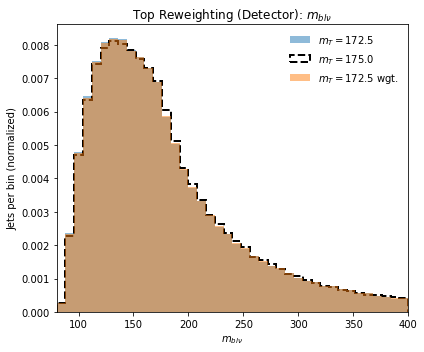

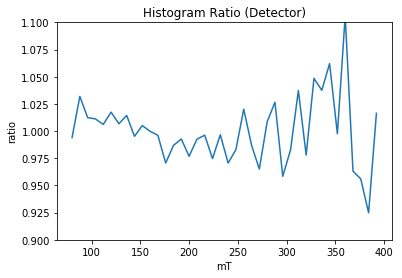

Truth Cor  0.9977650653484449
Det Cor  0.9997955517374569
theta:  171.0


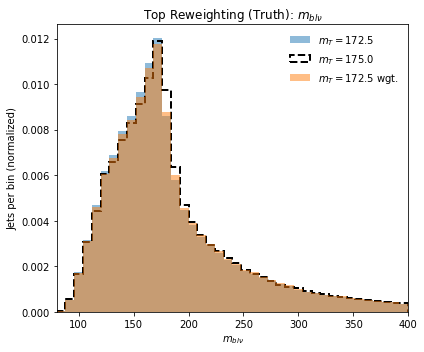

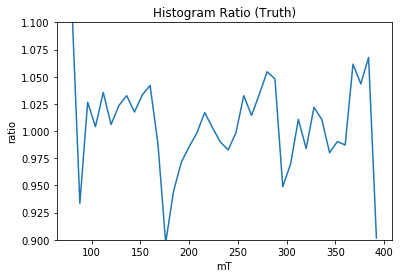

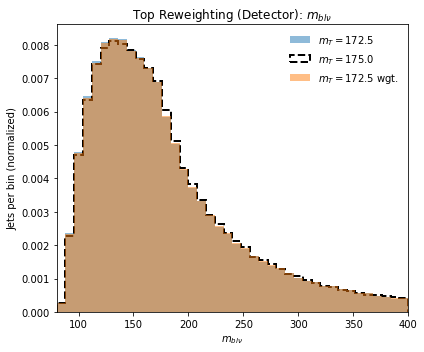

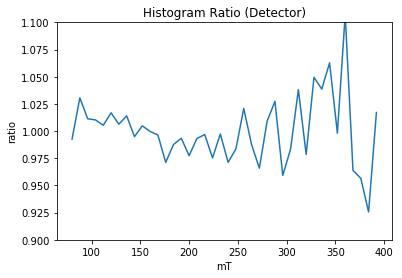

Truth Cor  0.9980271999149555
Det Cor  0.9998064613504337
theta:  171.5


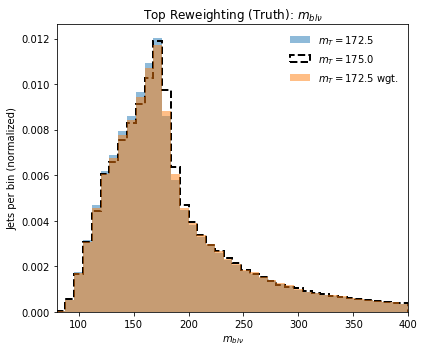

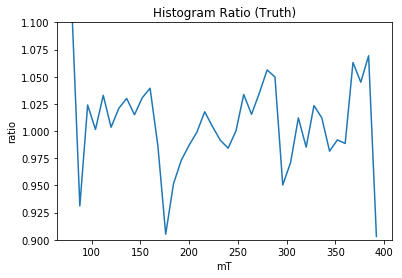

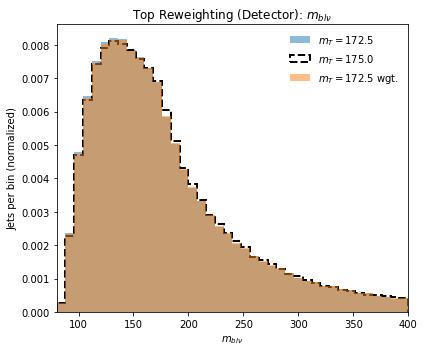

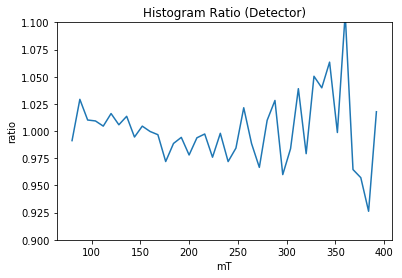

Truth Cor  0.9983144459225461
Det Cor  0.9998183807137332
theta:  172.0


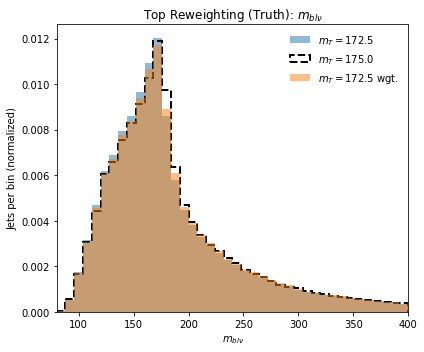

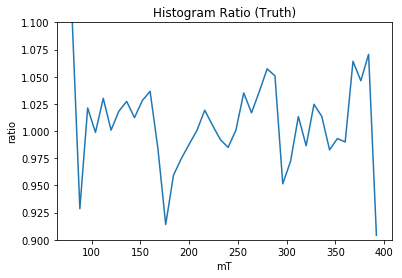

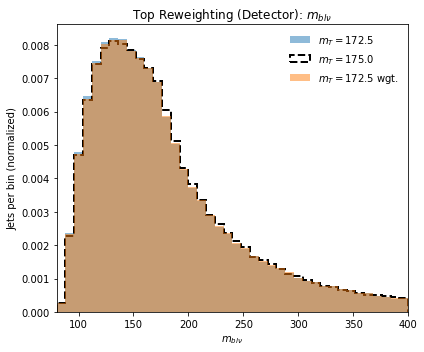

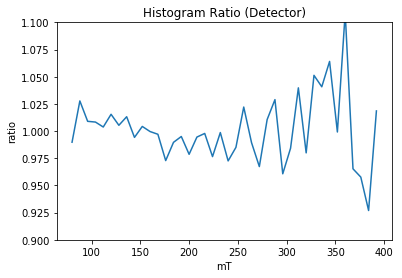

Truth Cor  0.9986010062371923
Det Cor  0.9998302055377919
theta:  172.5


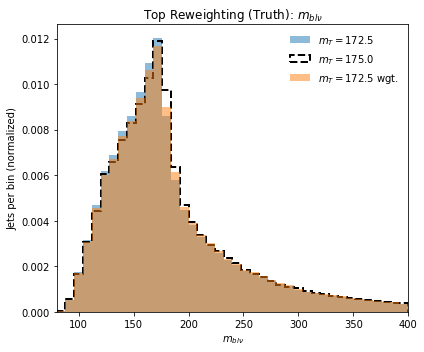

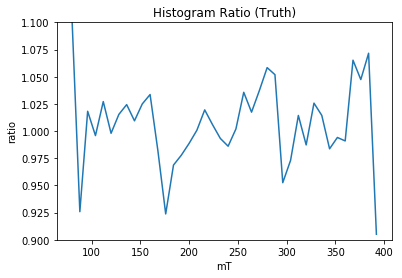

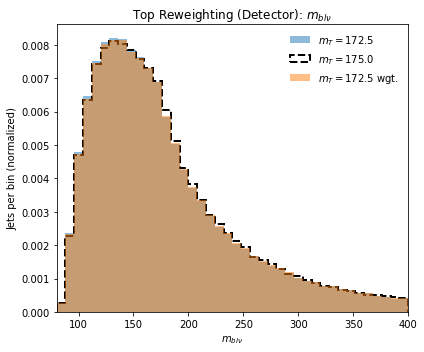

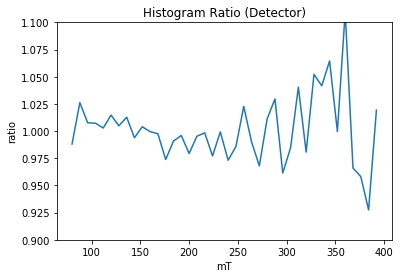

Truth Cor  0.9988814356185048
Det Cor  0.999842279568869
theta:  173.0


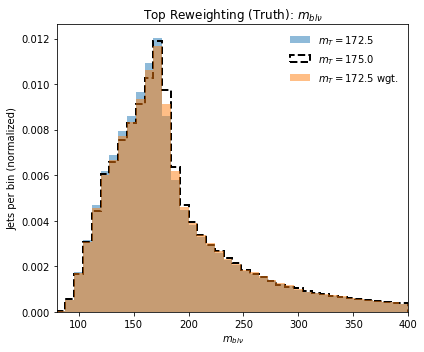

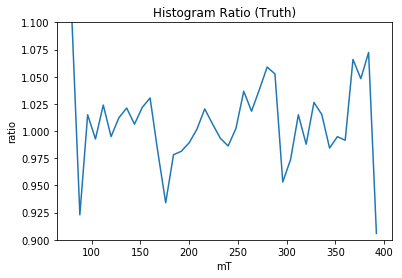

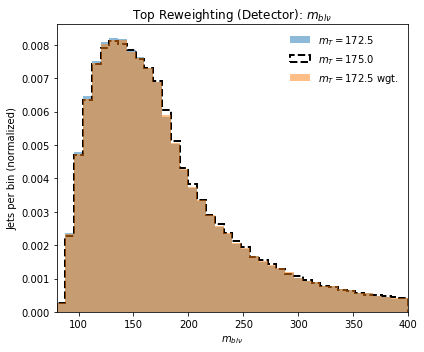

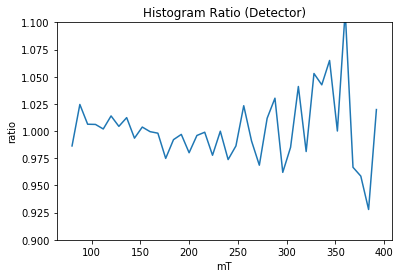

Truth Cor  0.9991365236245026
Det Cor  0.9998539874513903
theta:  173.5


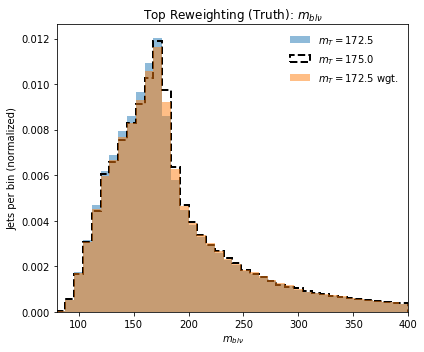

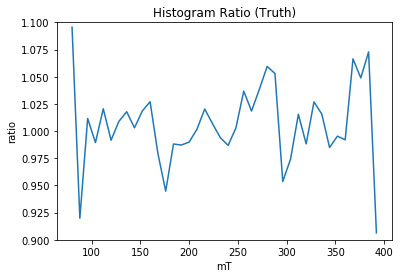

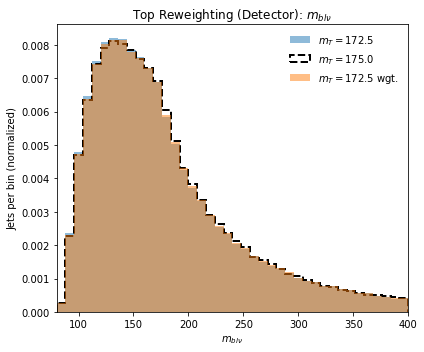

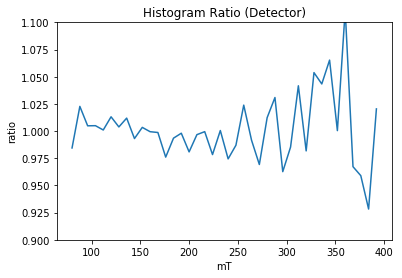

Truth Cor  0.9993600801902393
Det Cor  0.9998654198325193
theta:  174.0


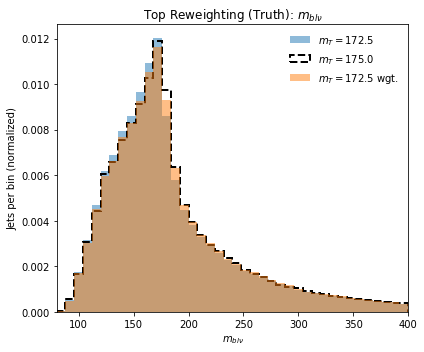

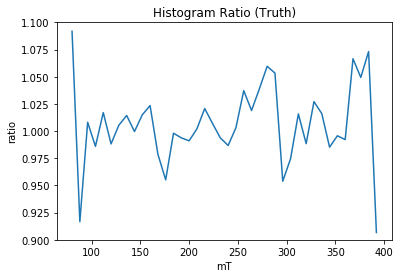

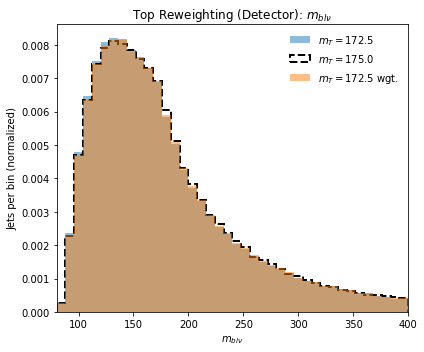

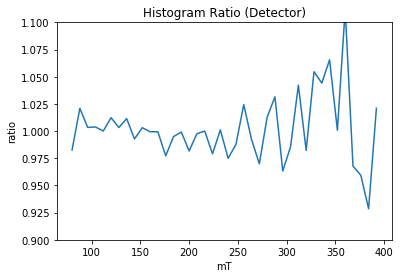

Truth Cor  0.9995349260594923
Det Cor  0.9998758633536515
theta:  174.5


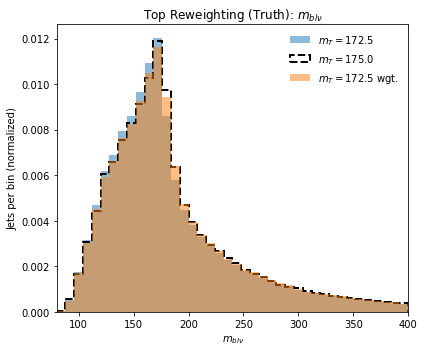

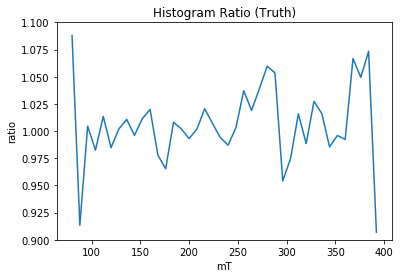

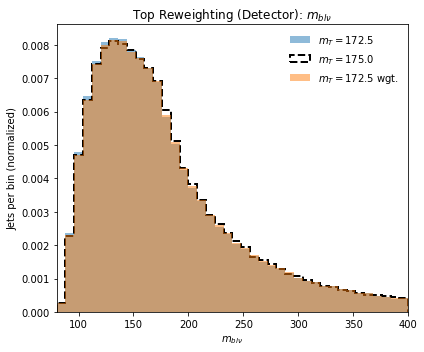

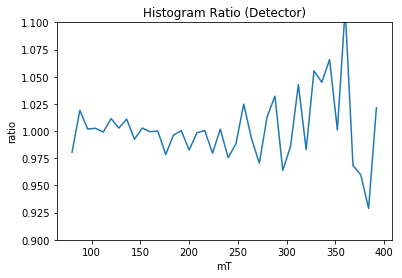

Truth Cor  0.9996571399557558
Det Cor  0.9998851096525503
theta:  175.0


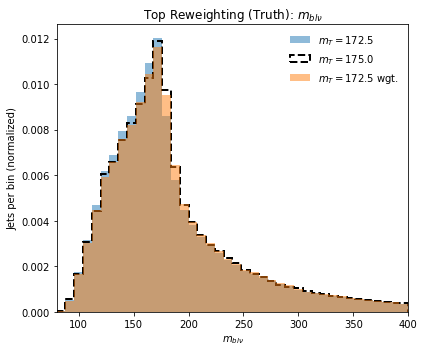

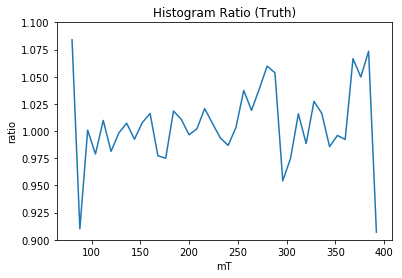

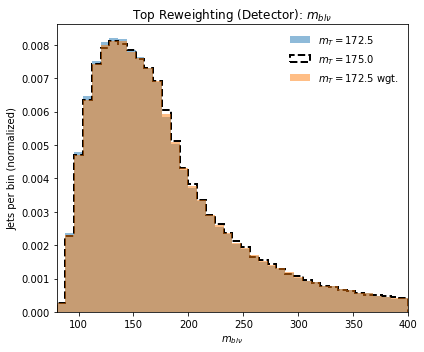

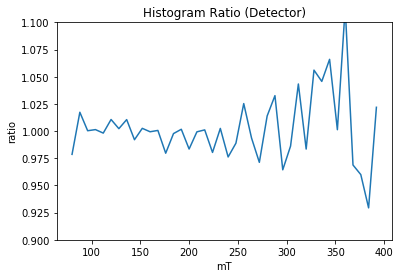

Truth Cor  0.9997252537396993
Det Cor  0.9998930548198957
theta:  175.5


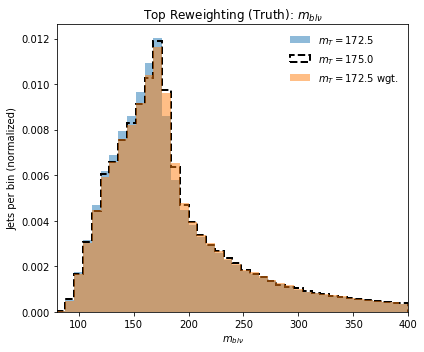

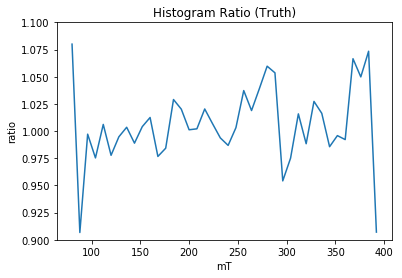

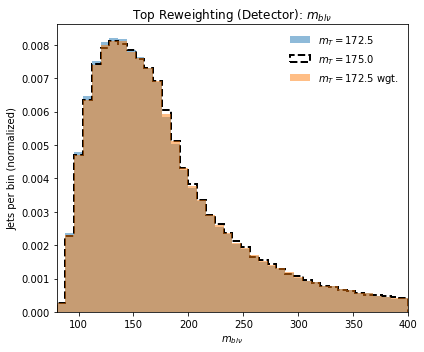

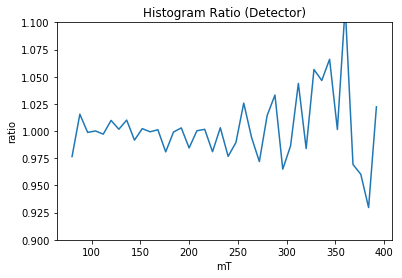

Truth Cor  0.9997399959654344
Det Cor  0.9998997422163899
theta:  176.0


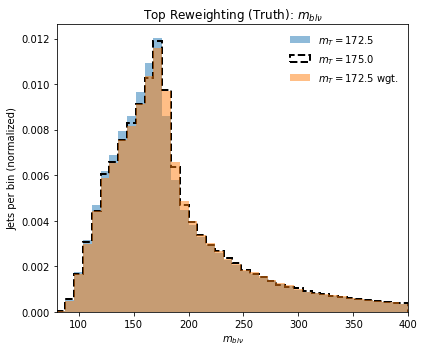

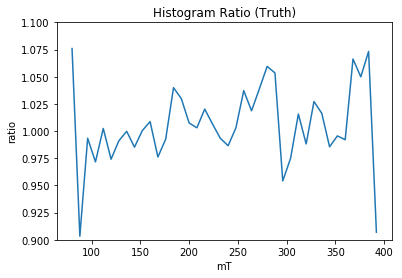

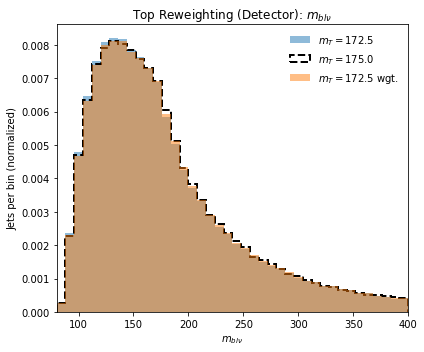

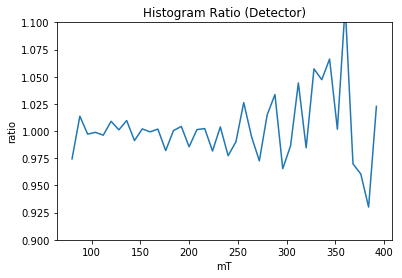

Truth Cor  0.9997006744405516
Det Cor  0.9999049169152046
theta:  176.5


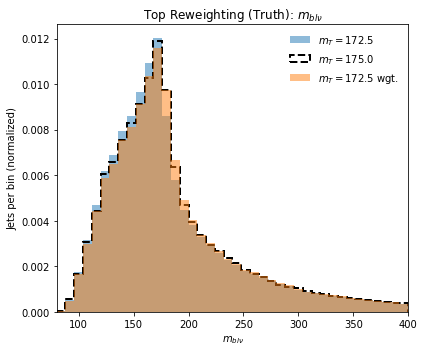

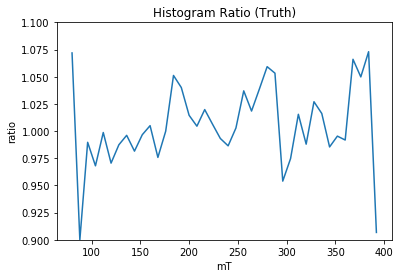

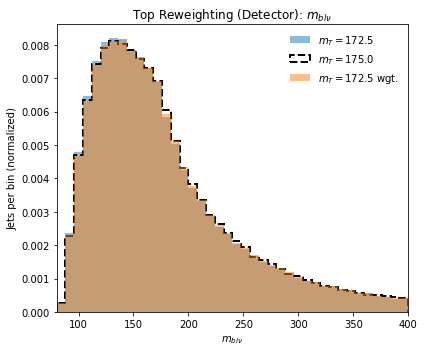

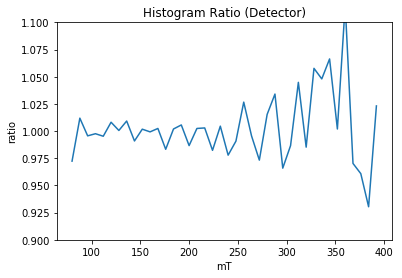

Truth Cor  0.9996107716844089
Det Cor  0.9999086582397999
theta:  177.0


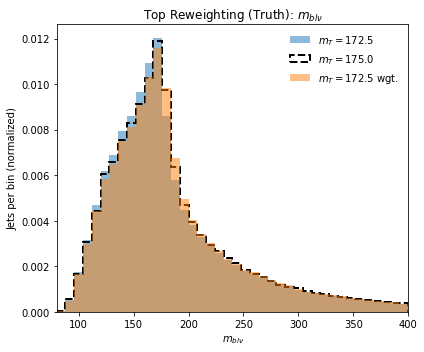

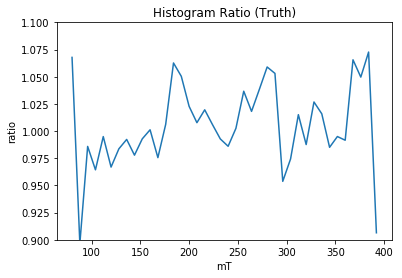

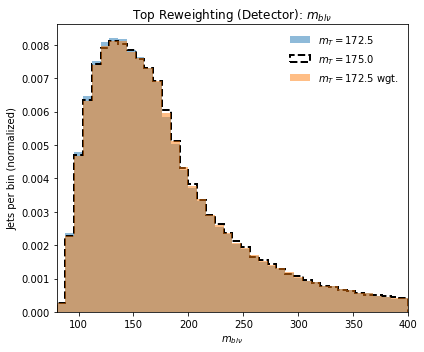

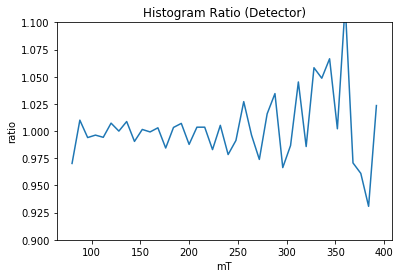

Truth Cor  0.9994728355770374
Det Cor  0.9999108603342347
theta:  177.5


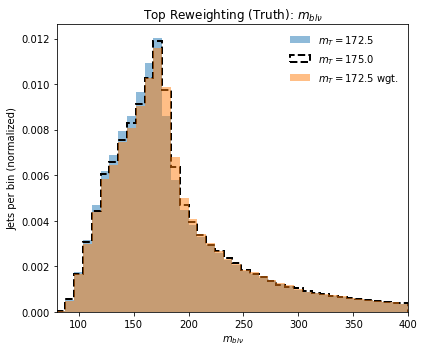

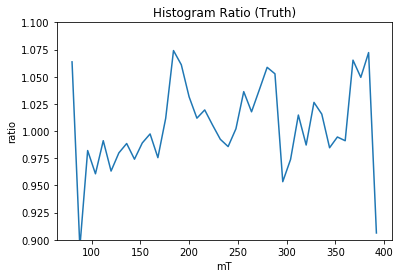

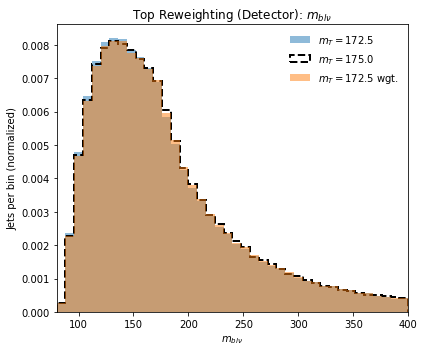

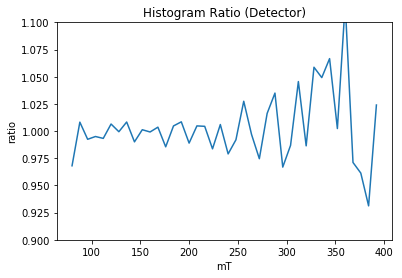

Truth Cor  0.9992912972083707
Det Cor  0.9999114704960526
theta:  178.0


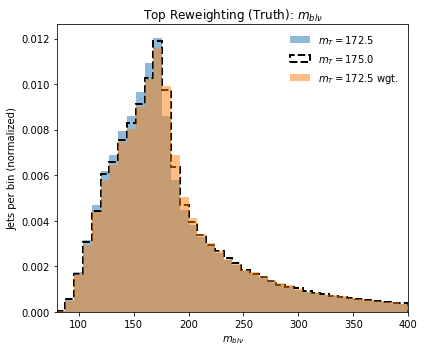

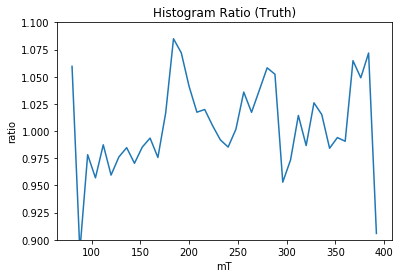

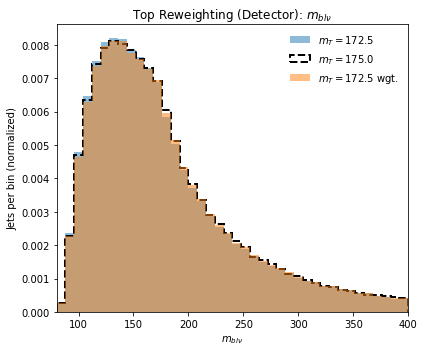

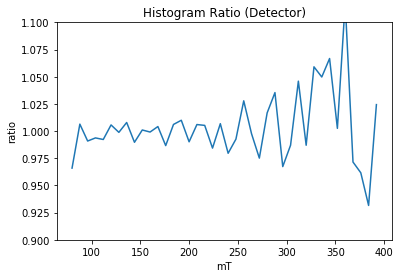

Truth Cor  0.9990696780284535
Det Cor  0.999910654873594
theta:  178.5


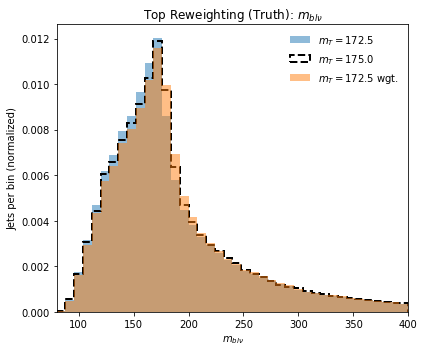

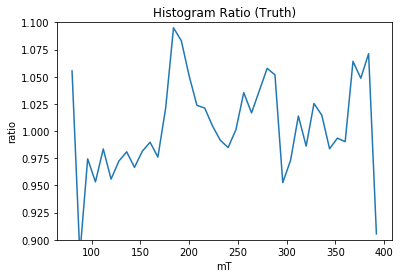

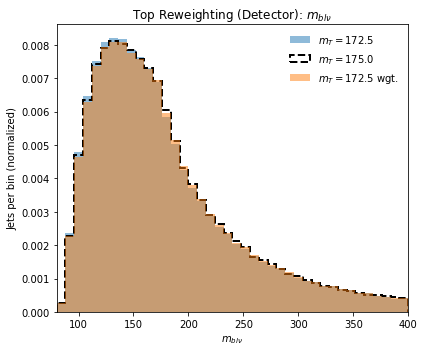

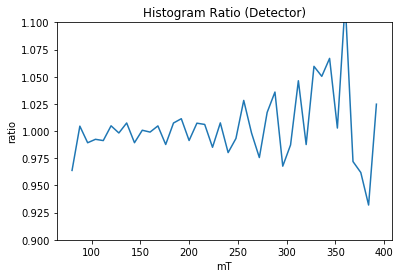

Truth Cor  0.9988120308649089
Det Cor  0.9999082045291444
theta:  179.0


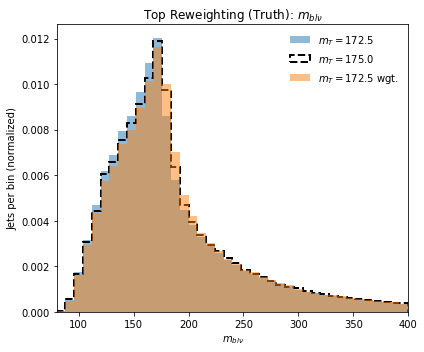

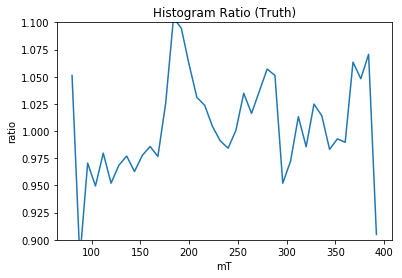

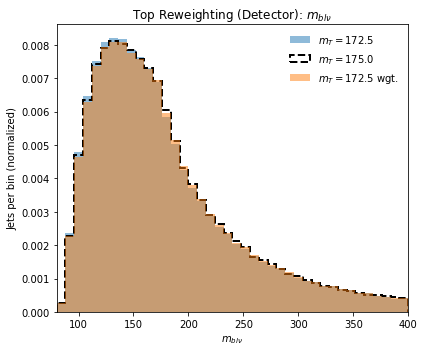

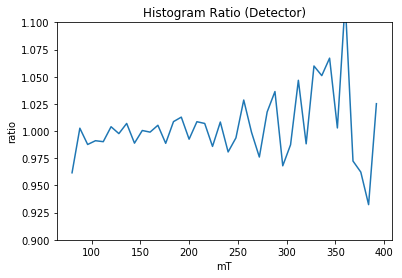

Truth Cor  0.9985198488274458
Det Cor  0.999904300199385
theta:  179.5


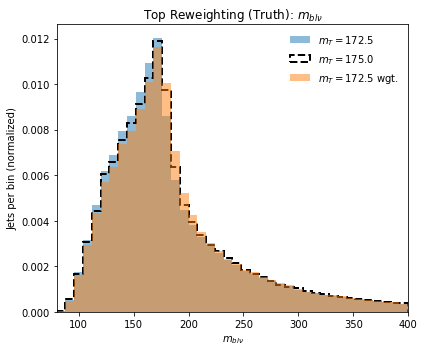

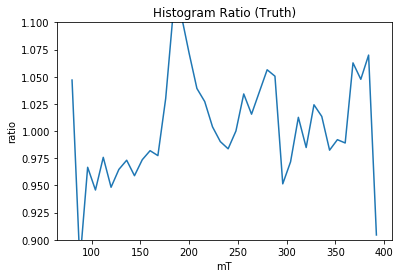

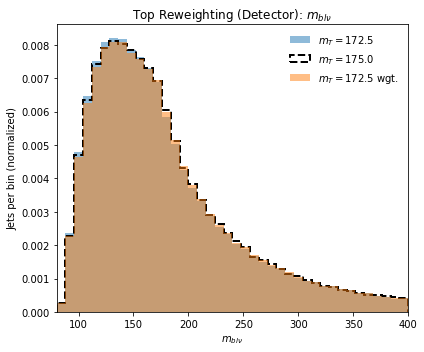

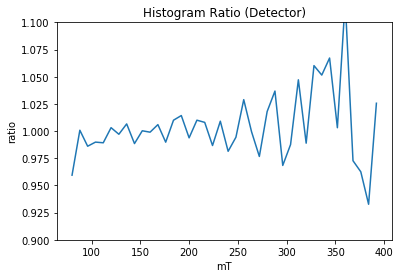

Truth Cor  0.9981971718781278
Det Cor  0.9998989199872141
theta:  180.0


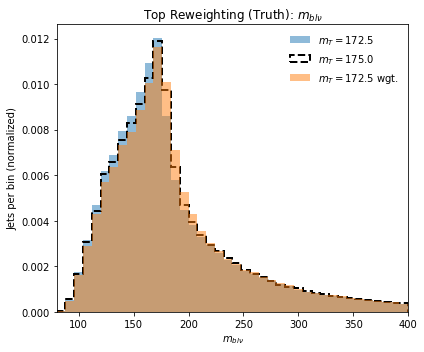

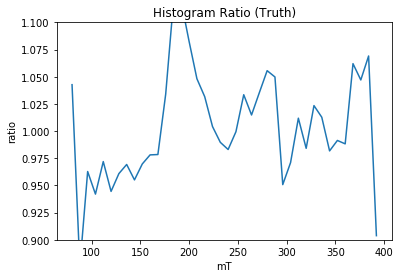

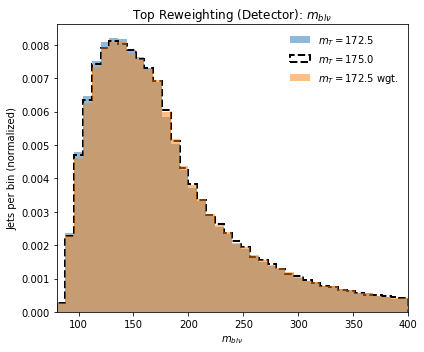

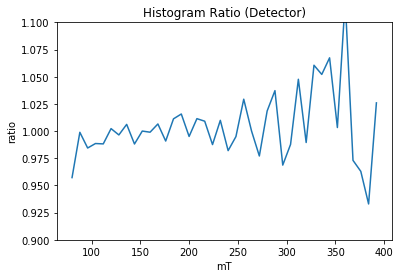

Truth Cor  0.9978449763927394
Det Cor  0.9998919107034082


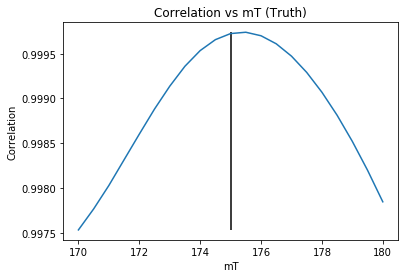

175.5


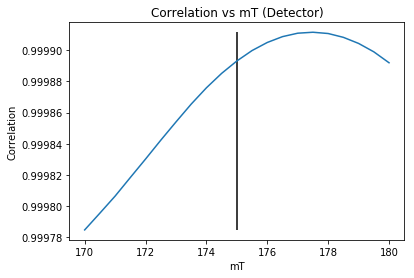

177.5
Weight Iteration:  2
theta:  170.0


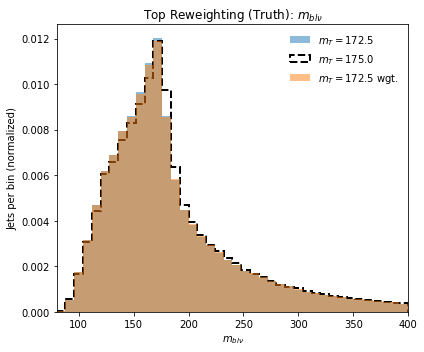

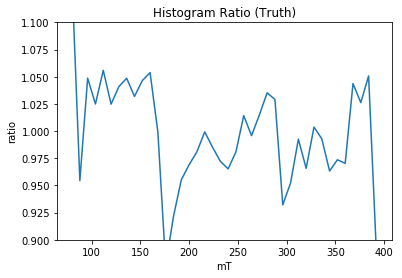

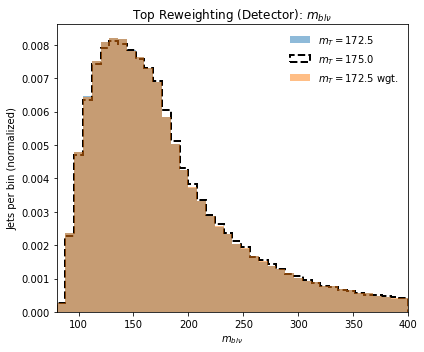

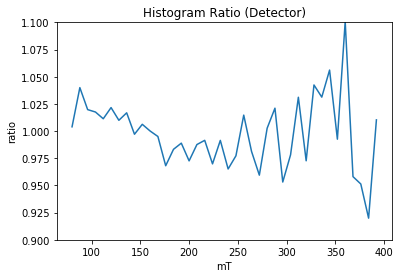

Truth Cor  0.9967878899298983
Det Cor  0.9997151888970338
theta:  170.5


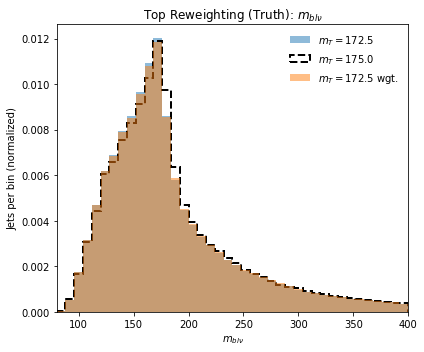

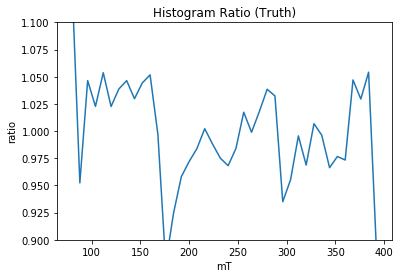

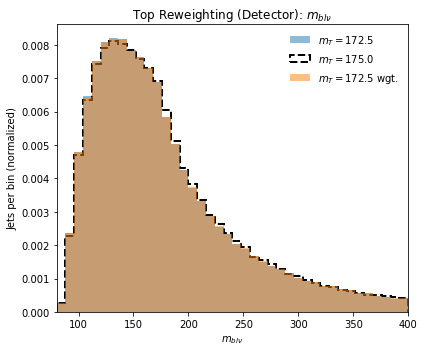

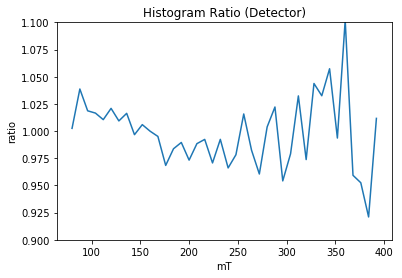

Truth Cor  0.9969372408657038
Det Cor  0.9997289943392954
theta:  171.0


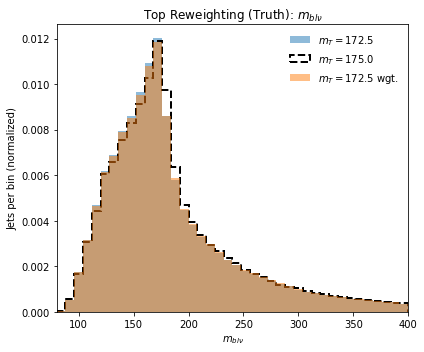

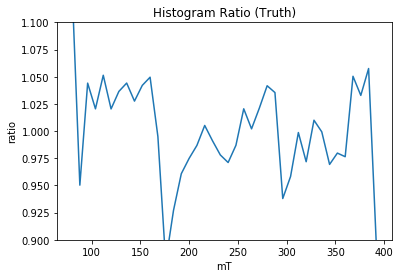

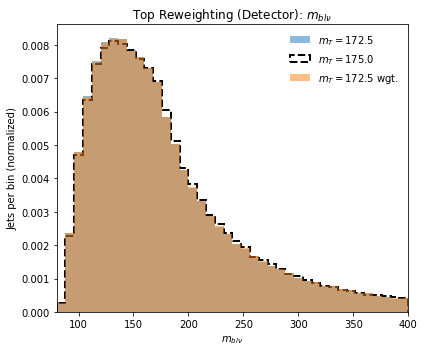

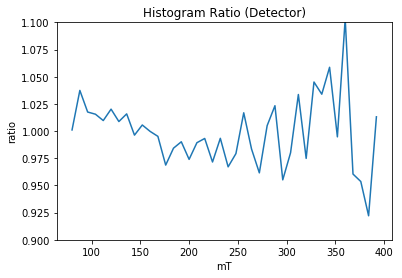

Truth Cor  0.9970970663530275
Det Cor  0.9997424929099197
theta:  171.5


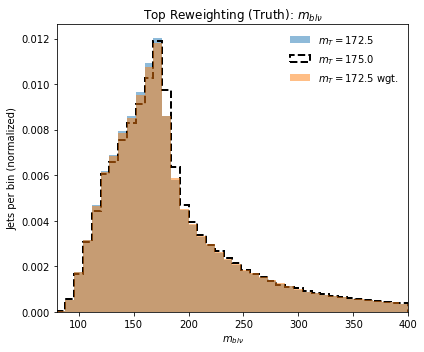

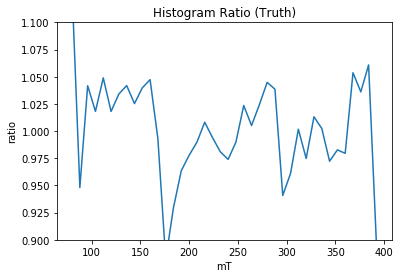

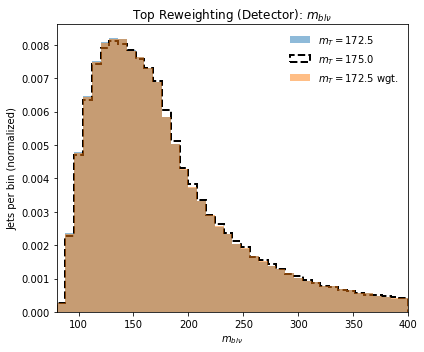

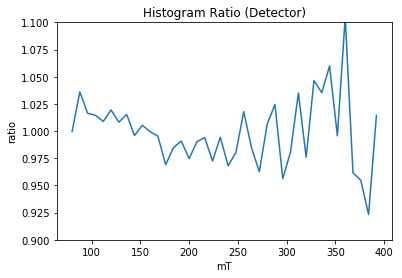

Truth Cor  0.9972753038427579
Det Cor  0.9997561387403646
theta:  172.0


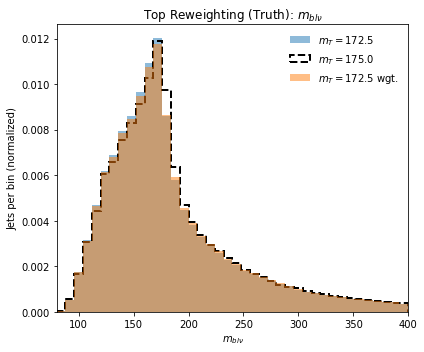

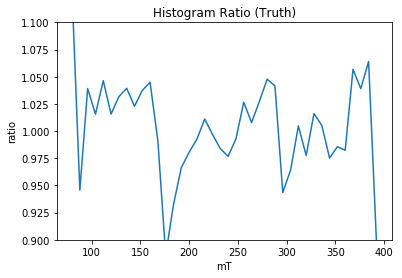

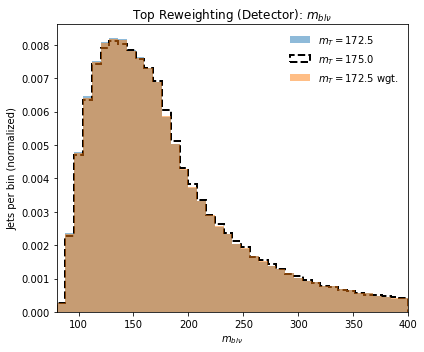

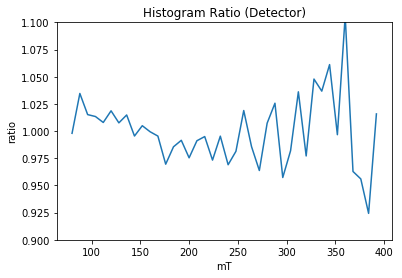

Truth Cor  0.9974883383643613
Det Cor  0.9997702008794278
theta:  172.5


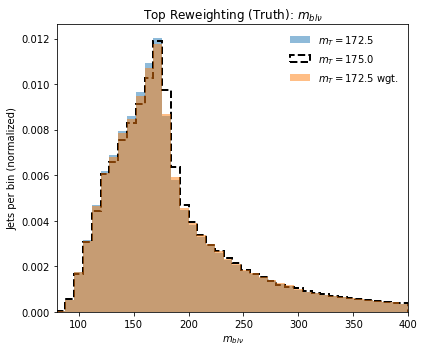

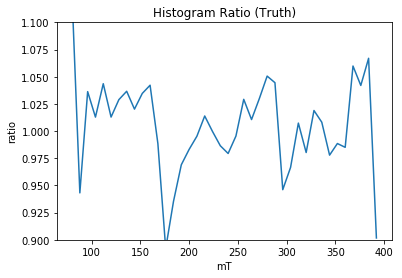

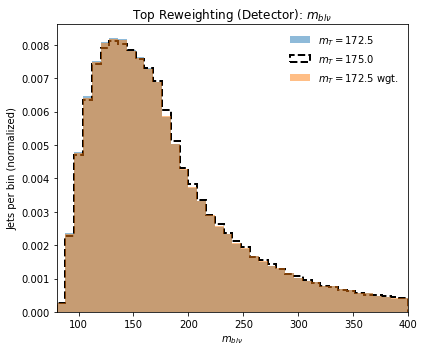

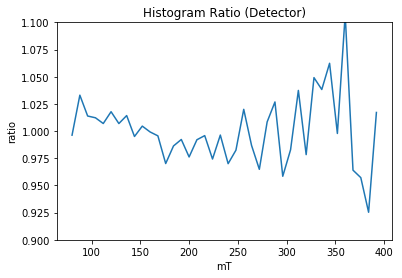

Truth Cor  0.9977568324813134
Det Cor  0.9997849461783307
theta:  173.0


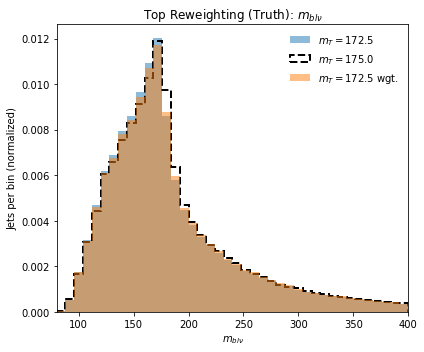

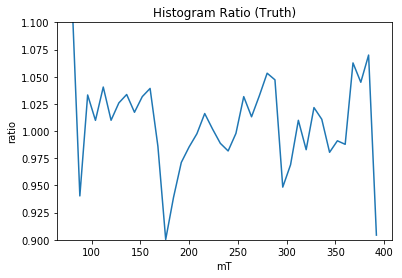

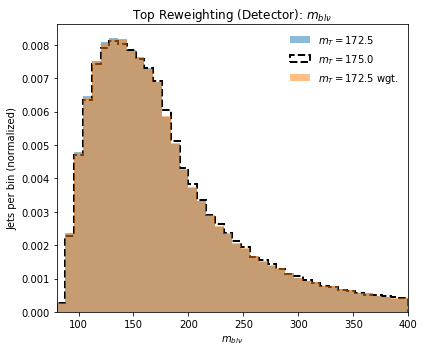

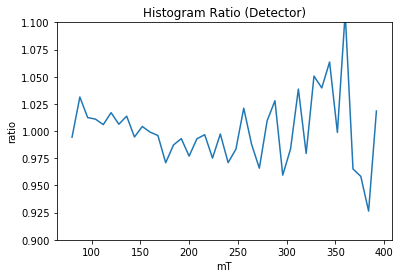

Truth Cor  0.9980706899411671
Det Cor  0.9998000943778752
theta:  173.5


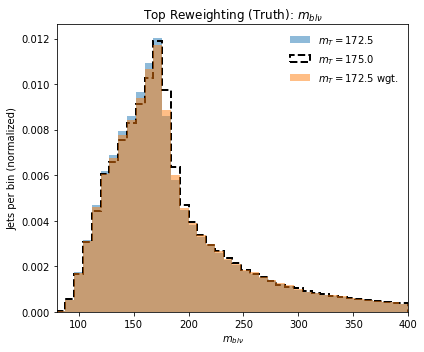

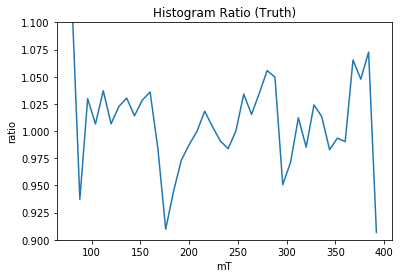

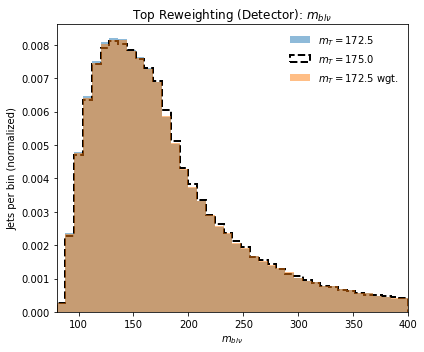

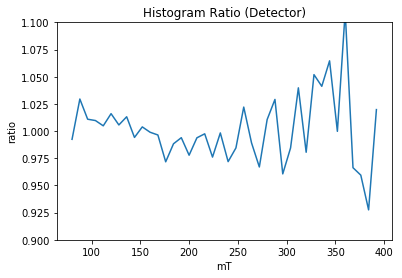

Truth Cor  0.998402721186769
Det Cor  0.99981572283372
theta:  174.0


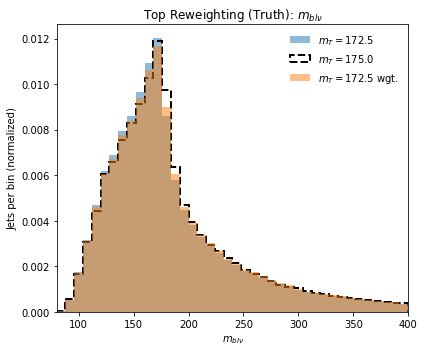

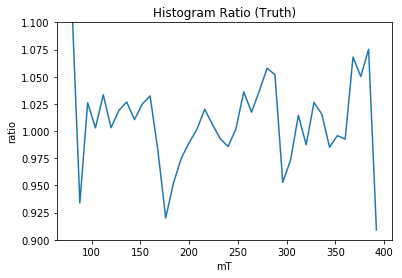

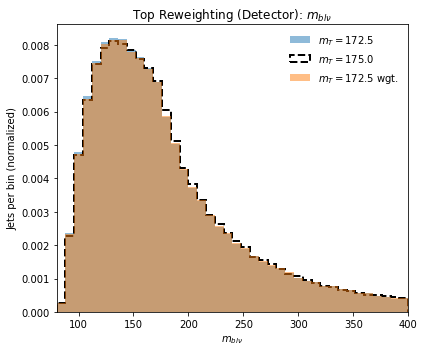

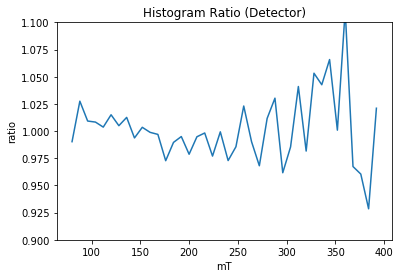

Truth Cor  0.9987349697195572
Det Cor  0.9998317268493925
theta:  174.5


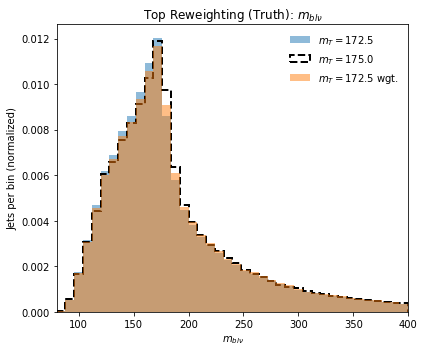

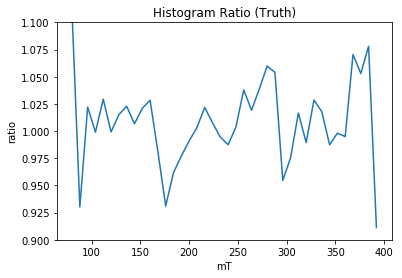

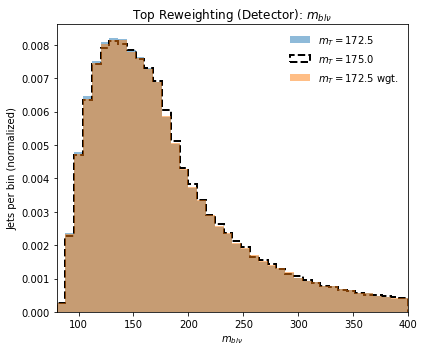

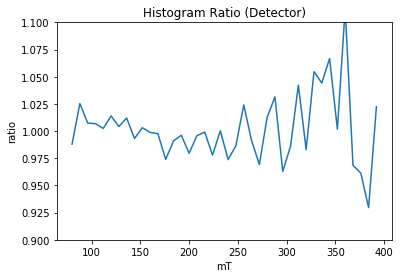

Truth Cor  0.9990494071263154
Det Cor  0.9998474585153637
theta:  175.0


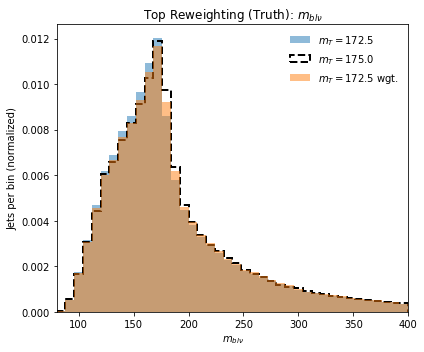

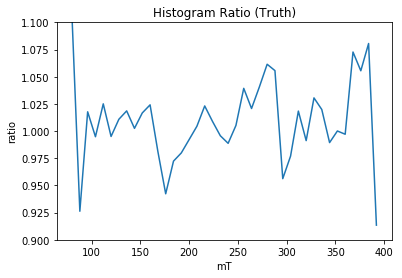

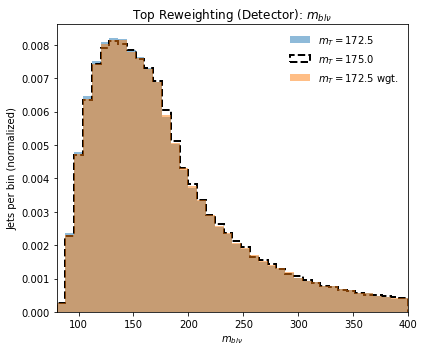

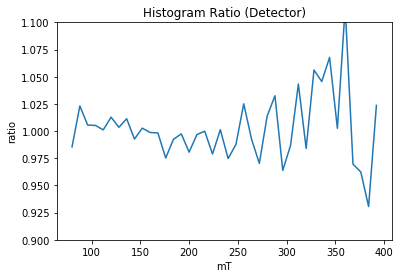

Truth Cor  0.999328679624989
Det Cor  0.9998625006414341
theta:  175.5


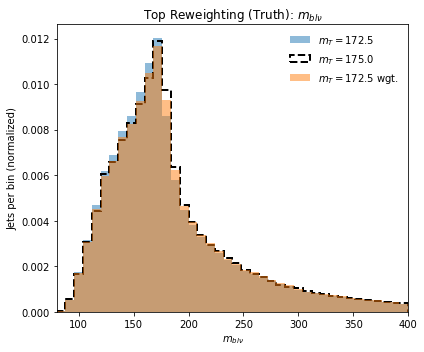

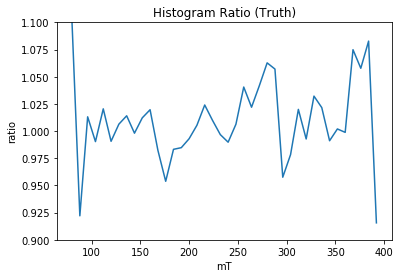

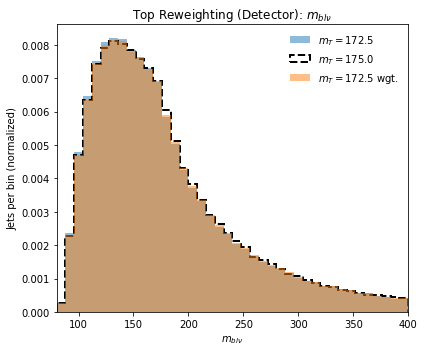

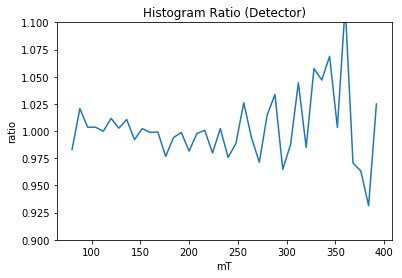

Truth Cor  0.9995616908686149
Det Cor  0.9998762801038982
theta:  176.0


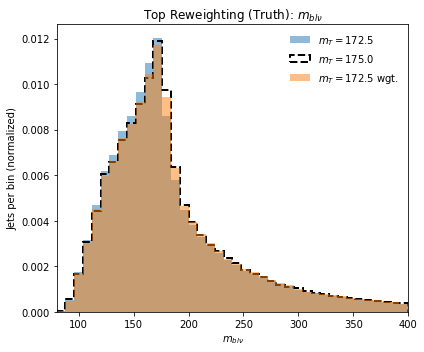

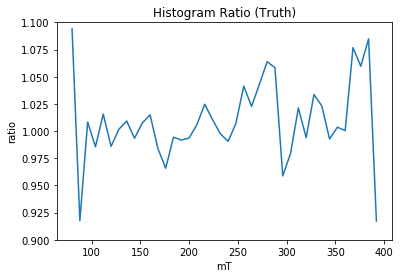

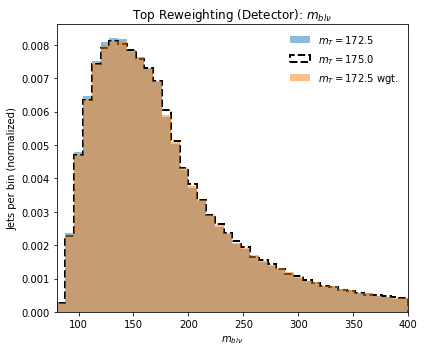

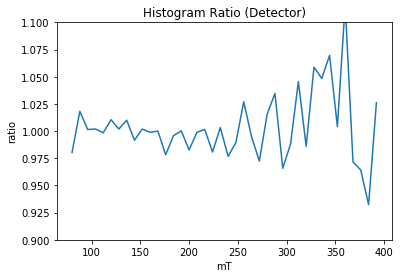

Truth Cor  0.9997367637069015
Det Cor  0.999888416037113
theta:  176.5


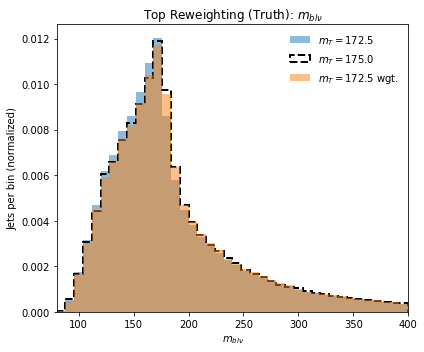

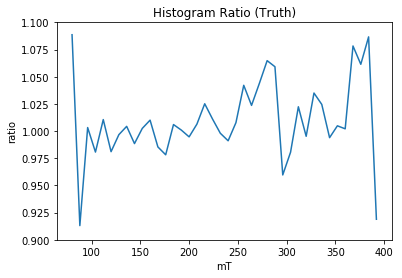

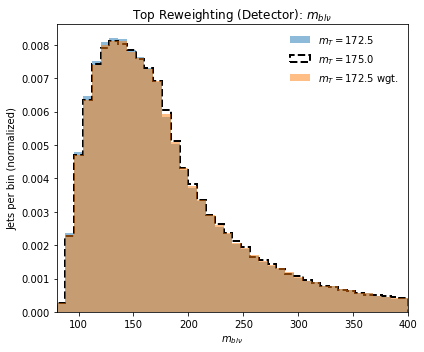

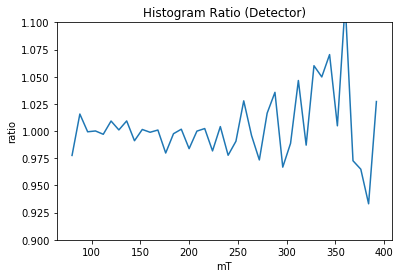

Truth Cor  0.9998387980589741
Det Cor  0.9998984739684272
theta:  177.0


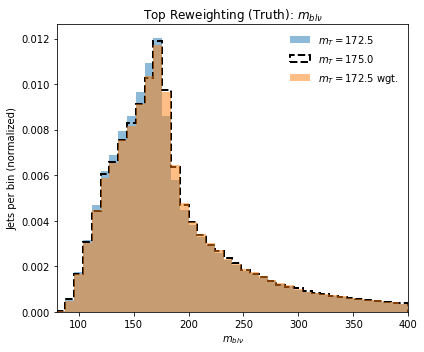

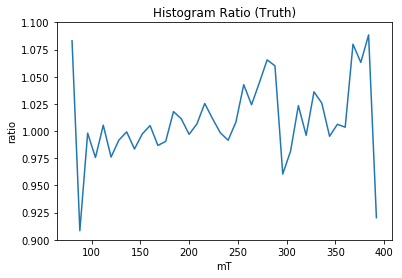

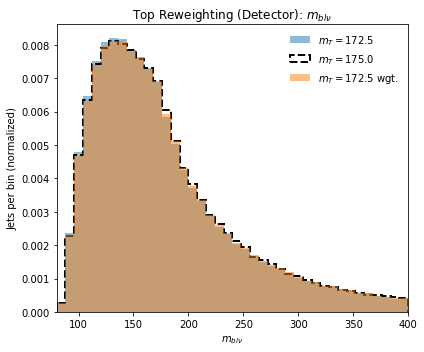

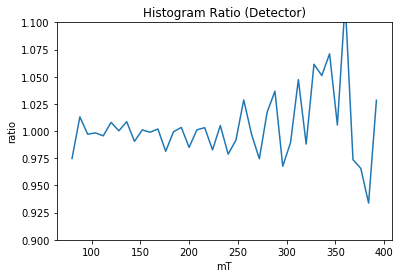

Truth Cor  0.999858456974318
Det Cor  0.9999059745789645
theta:  177.5


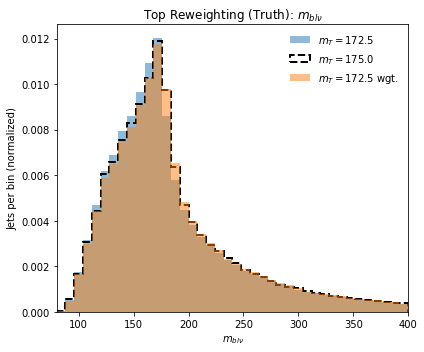

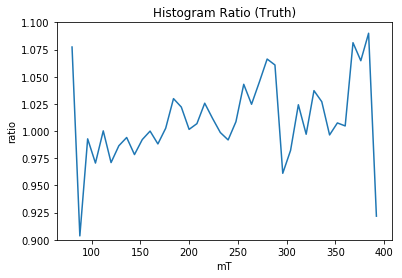

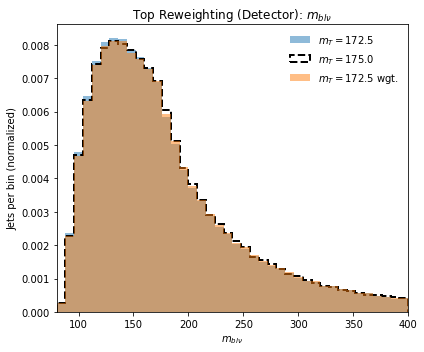

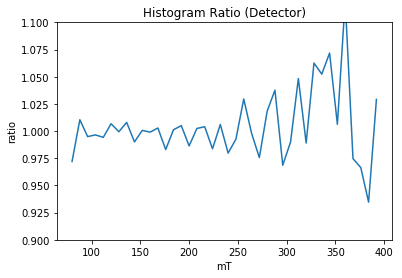

Truth Cor  0.9997930383664739
Det Cor  0.9999107799519698
theta:  178.0


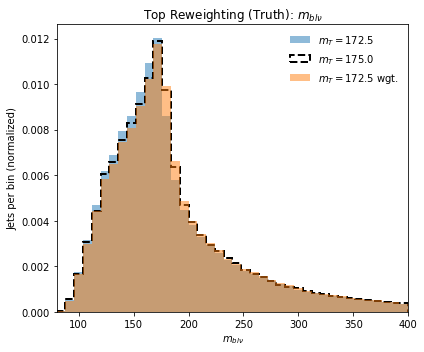

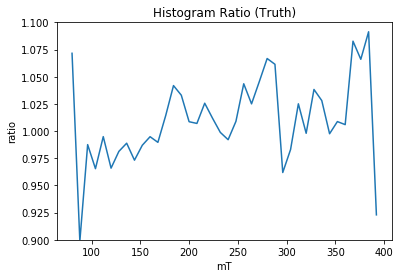

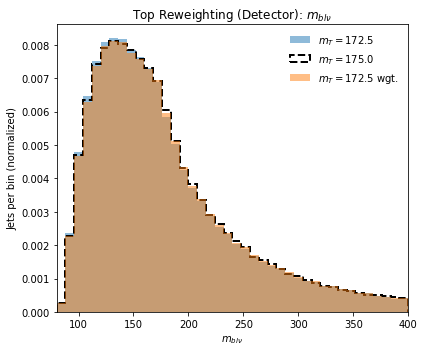

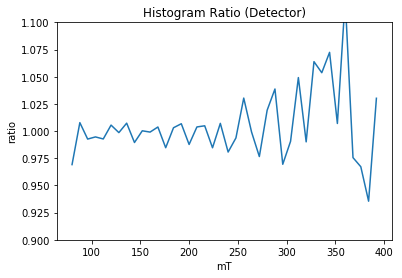

Truth Cor  0.9996431593684918
Det Cor  0.9999127041201711
theta:  178.5


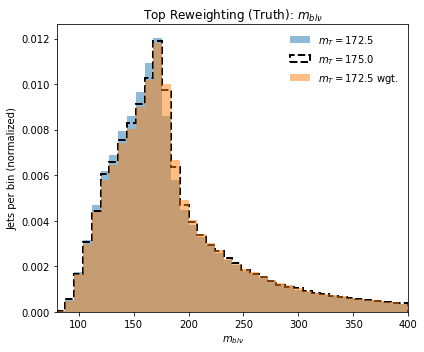

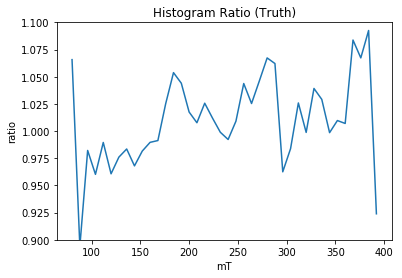

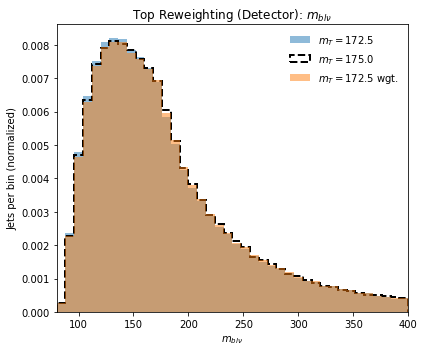

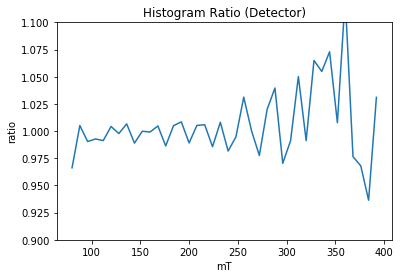

Truth Cor  0.9994111914509011
Det Cor  0.9999116570210639
theta:  179.0


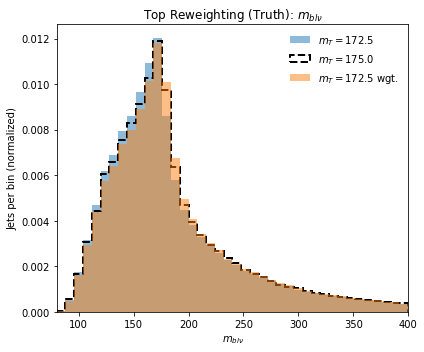

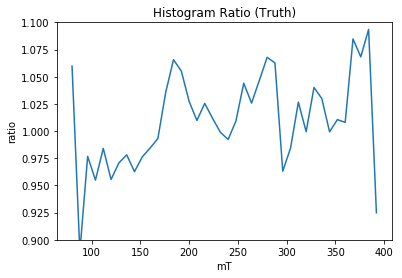

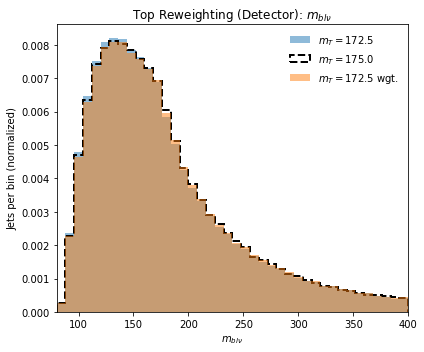

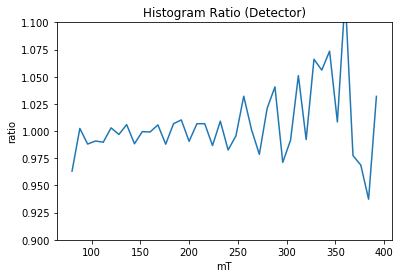

Truth Cor  0.9990992028269009
Det Cor  0.9999074564271182
theta:  179.5


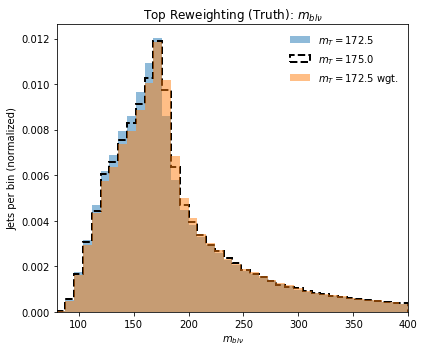

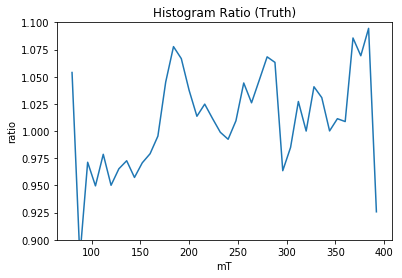

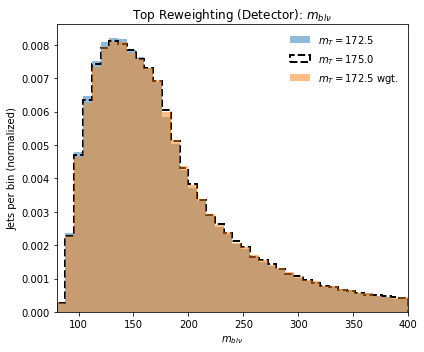

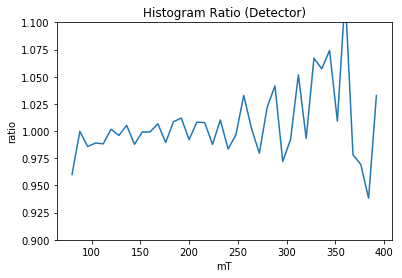

Truth Cor  0.9987118572231163
Det Cor  0.9999004256136128
theta:  180.0


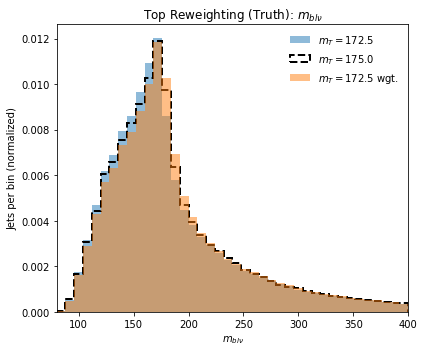

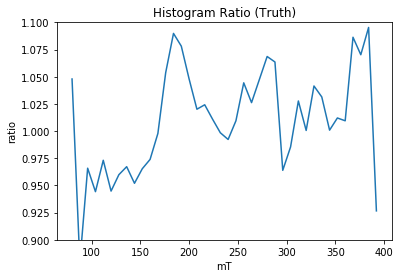

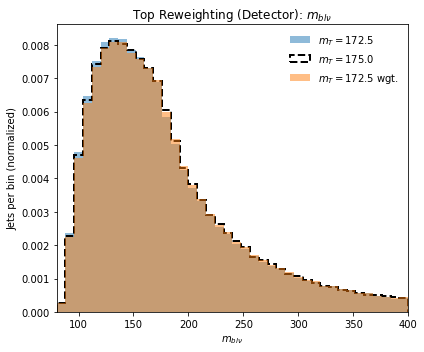

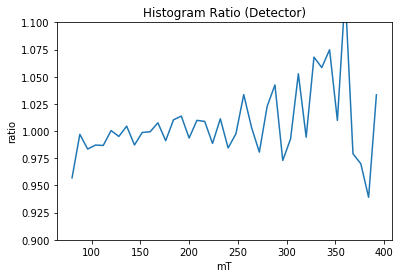

Truth Cor  0.9982518141497098
Det Cor  0.9998900552291123


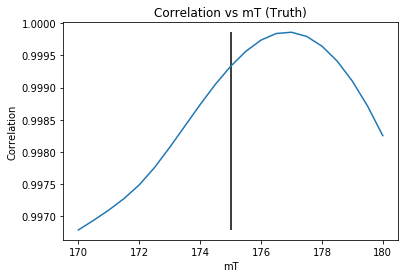

177.0


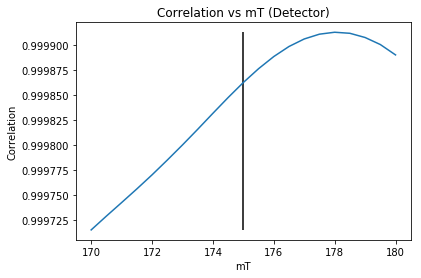

178.0
Weight Iteration:  3
theta:  170.0


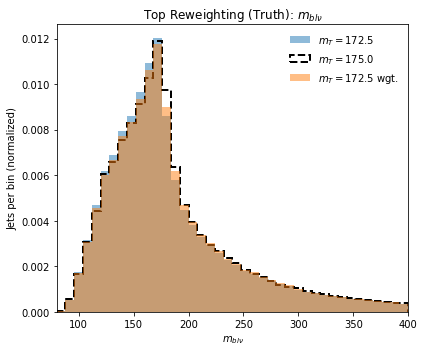

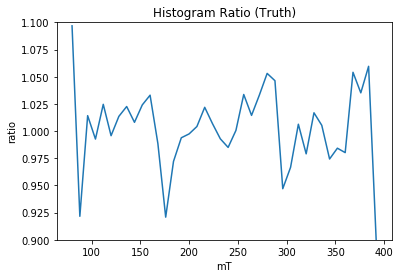

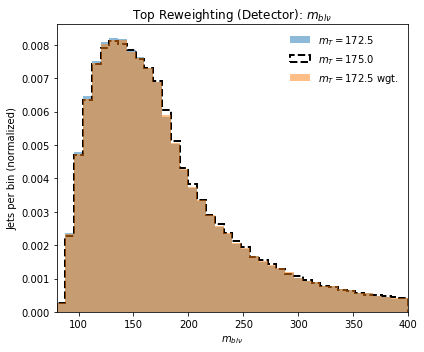

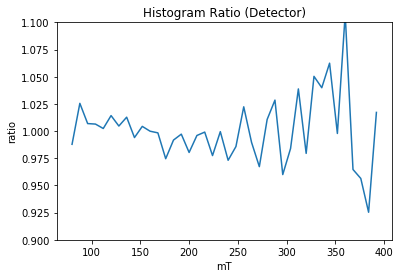

Truth Cor  0.9989043388835325
Det Cor  0.9998513622291727
theta:  170.5


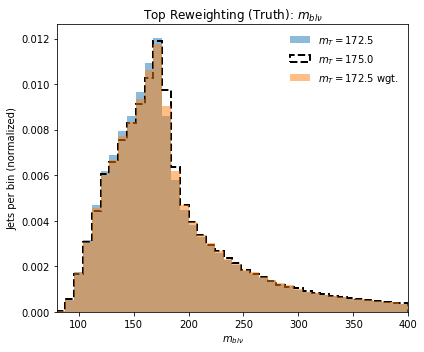

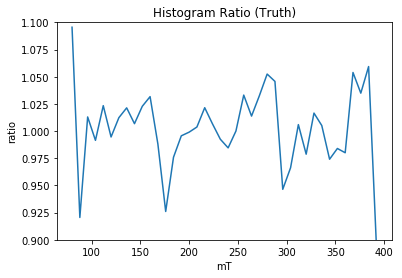

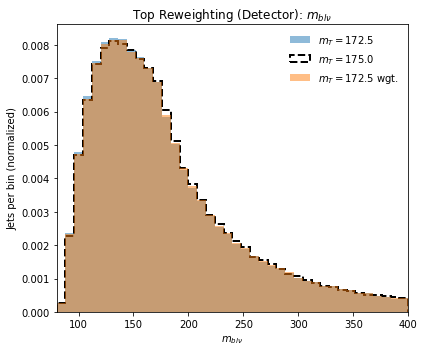

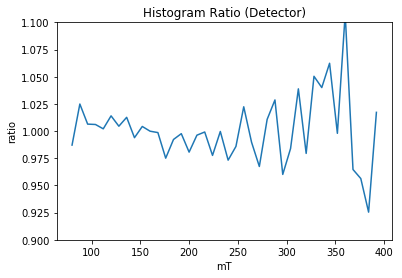

Truth Cor  0.9990321864153918
Det Cor  0.9998557599908335
theta:  171.0


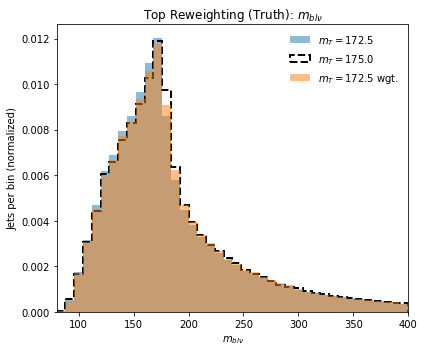

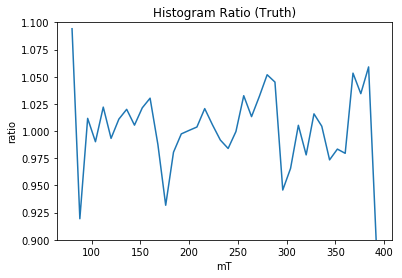

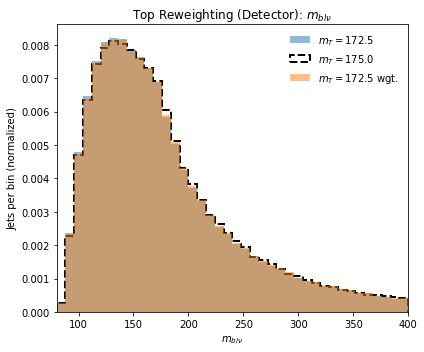

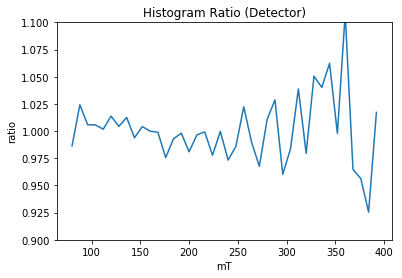

Truth Cor  0.9991616525139418
Det Cor  0.9998604376973503
theta:  171.5


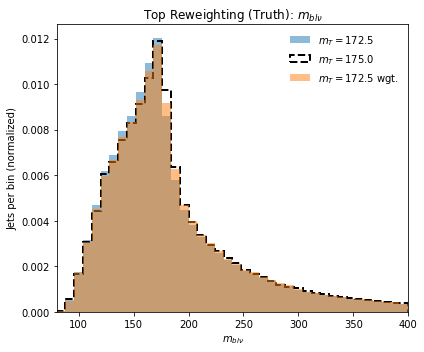

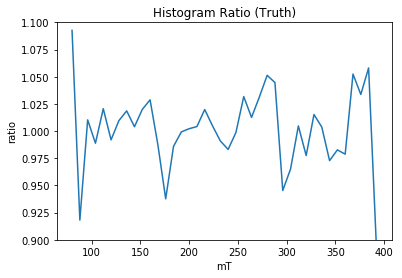

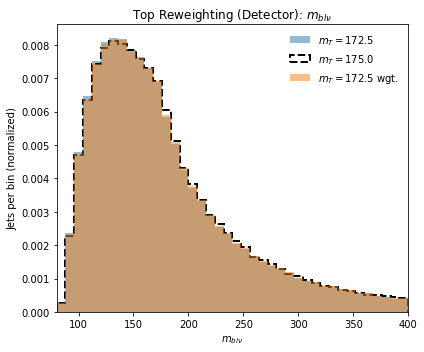

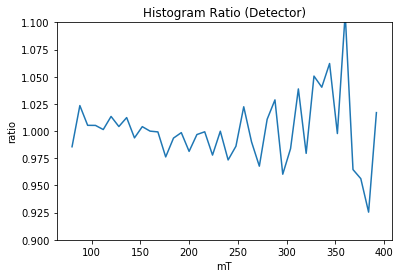

Truth Cor  0.9992845898435277
Det Cor  0.9998651675554929
theta:  172.0


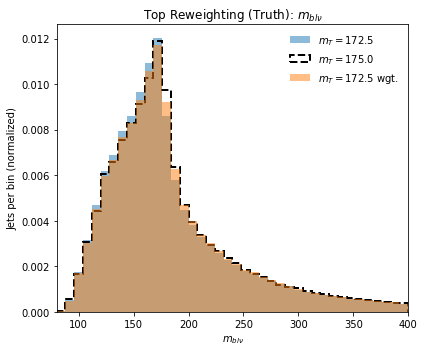

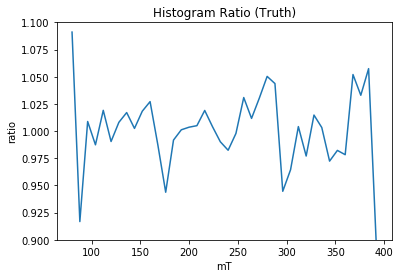

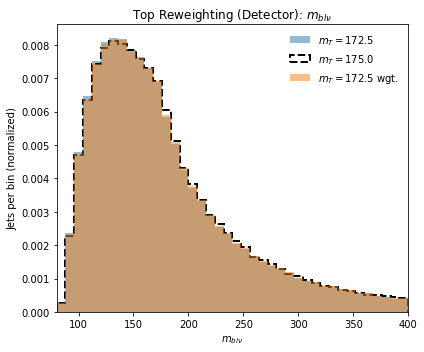

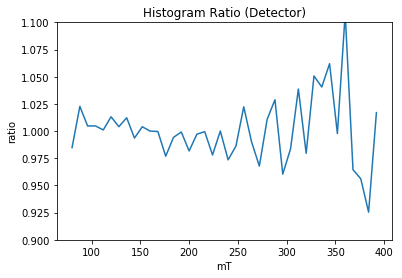

Truth Cor  0.9993982924298251
Det Cor  0.9998699938393997
theta:  172.5


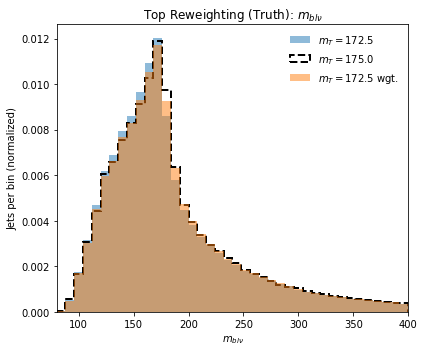

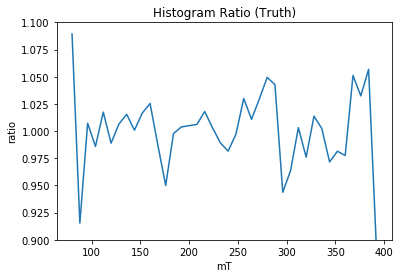

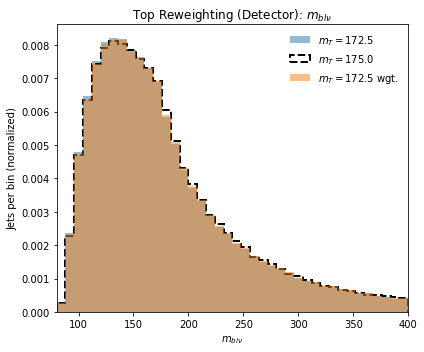

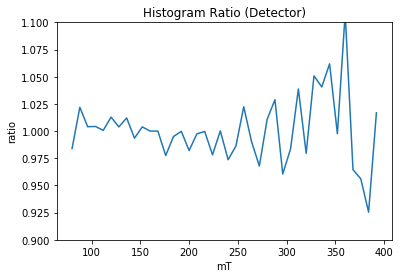

Truth Cor  0.9994998039446698
Det Cor  0.999874841205272
theta:  173.0


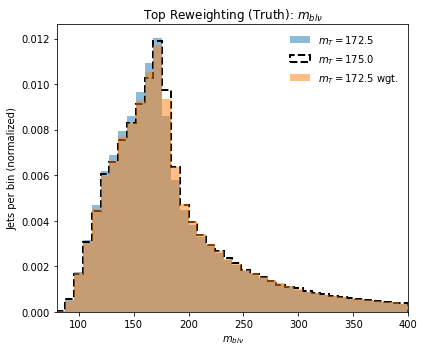

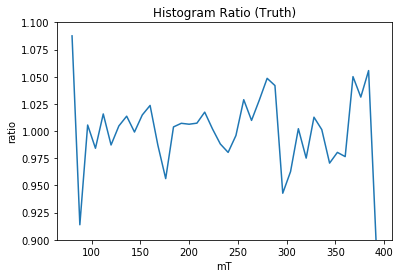

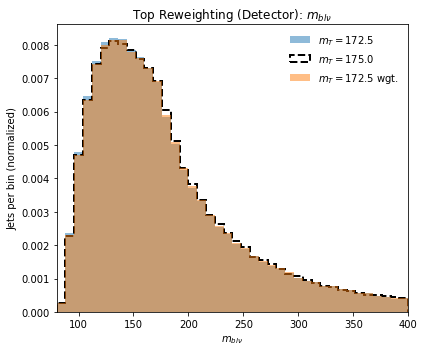

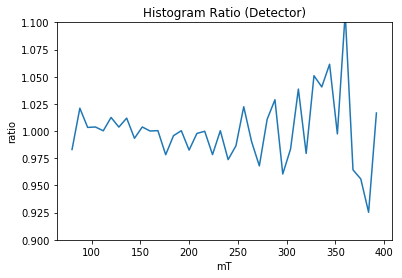

Truth Cor  0.9995874513113276
Det Cor  0.9998795810874971
theta:  173.5


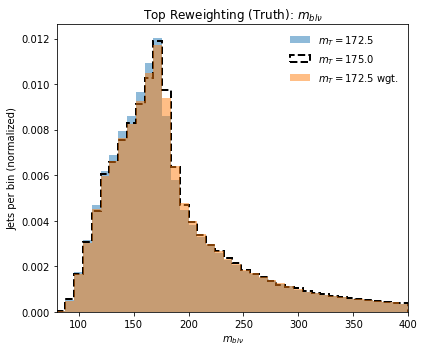

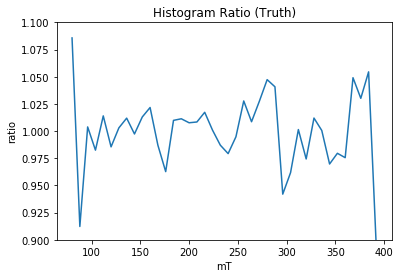

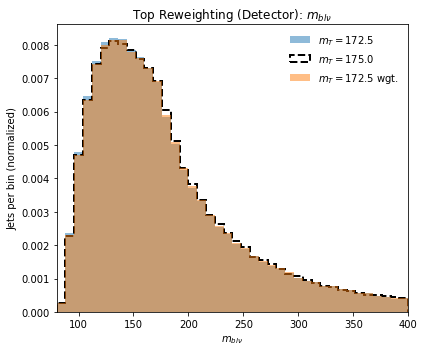

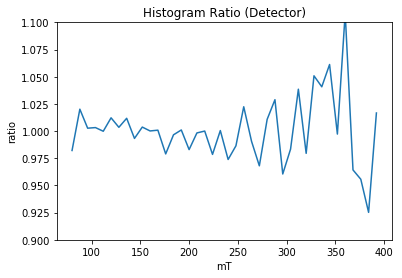

Truth Cor  0.9996598149775852
Det Cor  0.9998842243286192
theta:  174.0


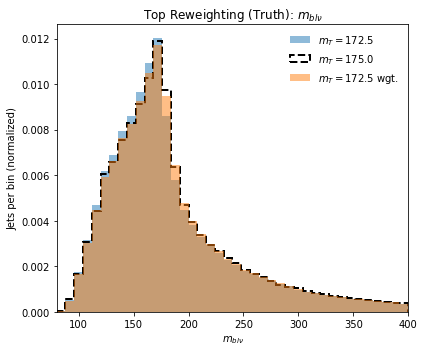

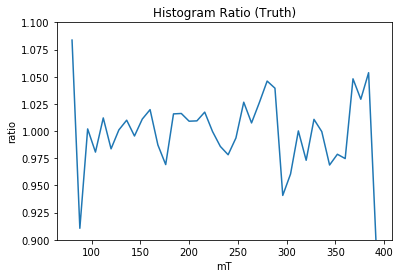

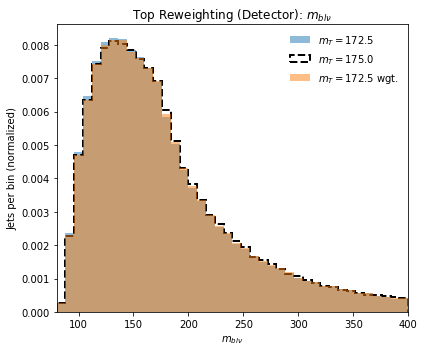

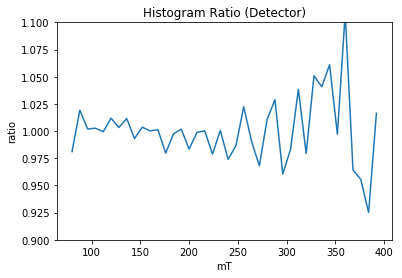

Truth Cor  0.999715214114947
Det Cor  0.9998887975286105
theta:  174.5


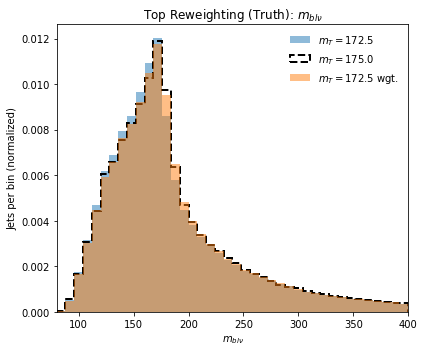

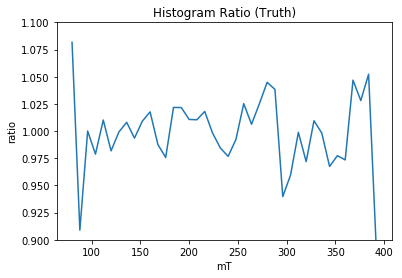

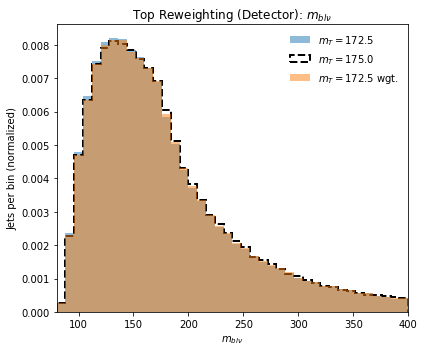

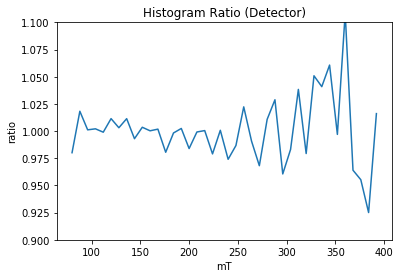

Truth Cor  0.9997524775540866
Det Cor  0.9998928859915994
theta:  175.0


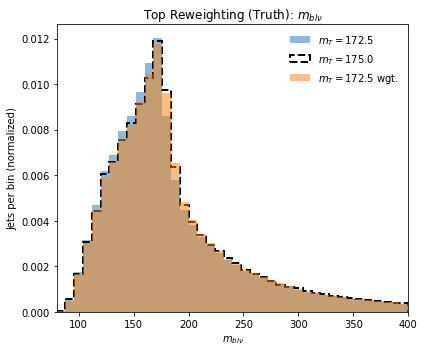

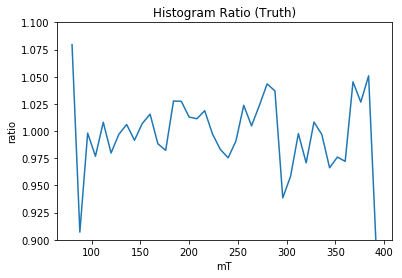

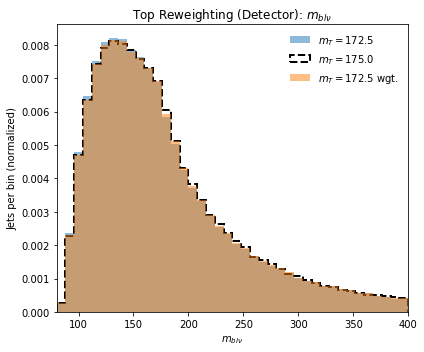

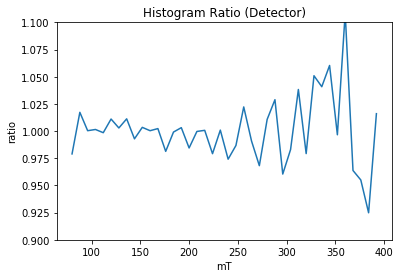

Truth Cor  0.9997710766025133
Det Cor  0.9998967339054031
theta:  175.5


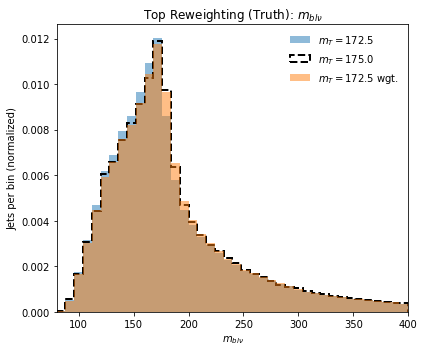

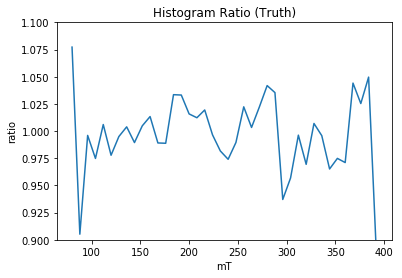

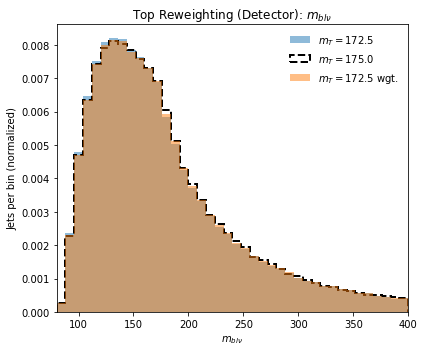

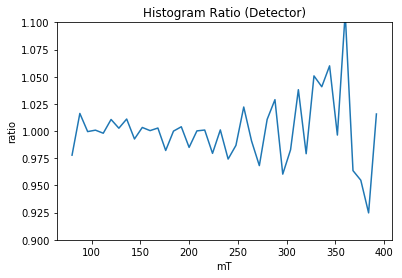

Truth Cor  0.9997700650489139
Det Cor  0.999900291331851
theta:  176.0


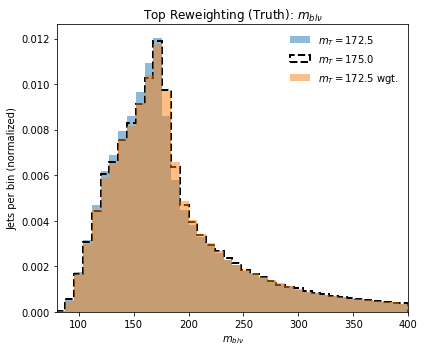

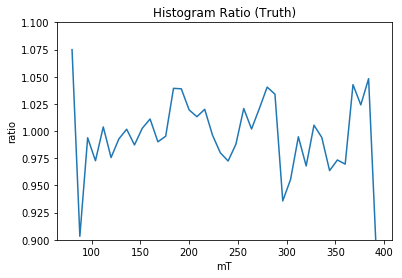

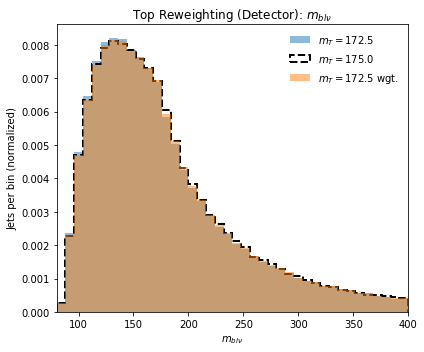

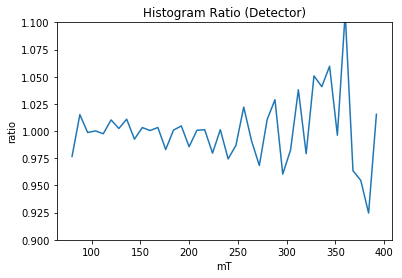

Truth Cor  0.9997488846401168
Det Cor  0.9999034745023726
theta:  176.5


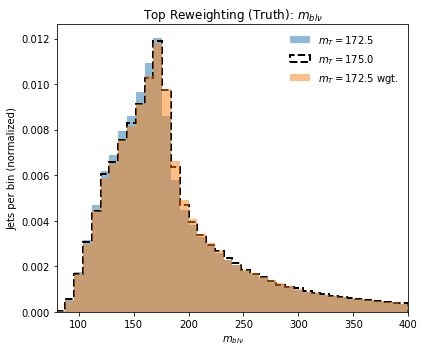

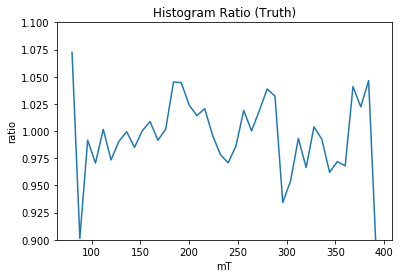

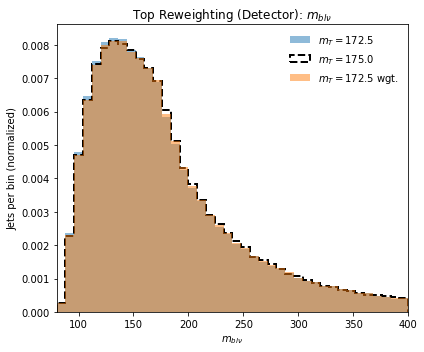

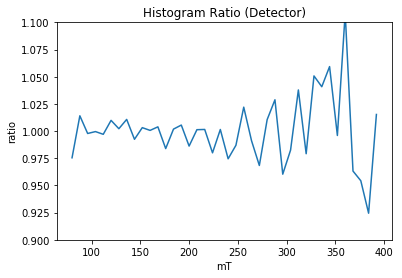

Truth Cor  0.9997070873394818
Det Cor  0.9999061652778103
theta:  177.0


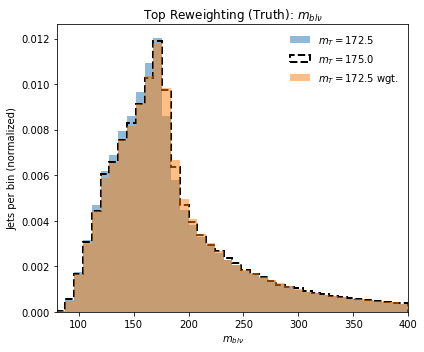

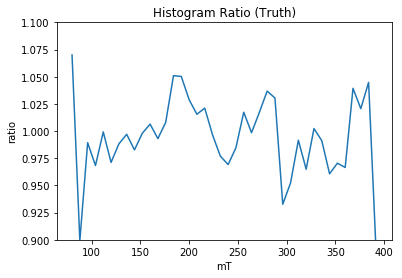

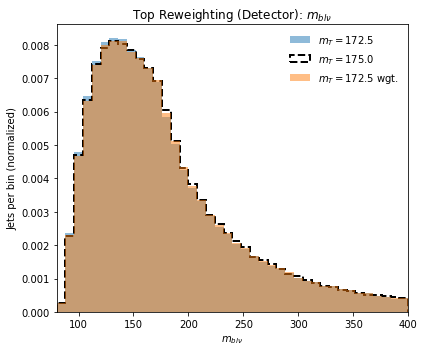

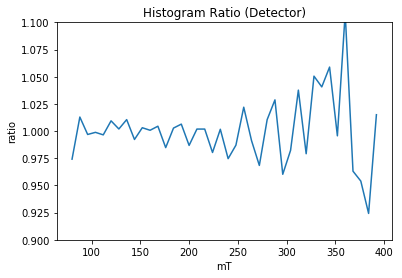

Truth Cor  0.9996433974466564
Det Cor  0.9999083347324123
theta:  177.5


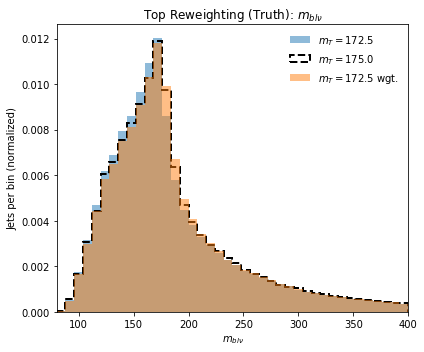

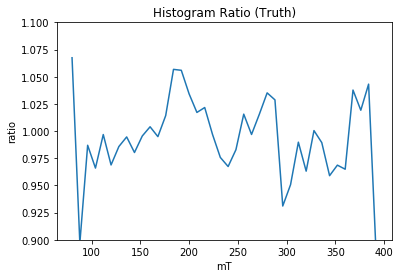

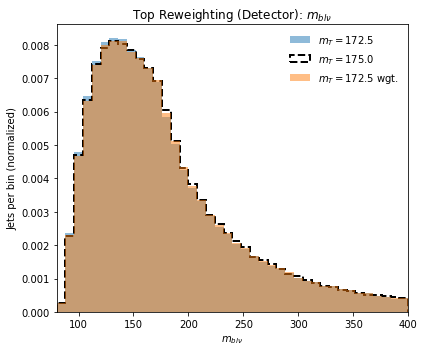

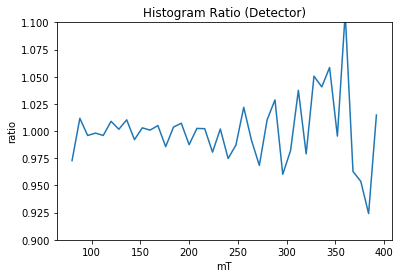

Truth Cor  0.9995576887095906
Det Cor  0.9999100033513924
theta:  178.0


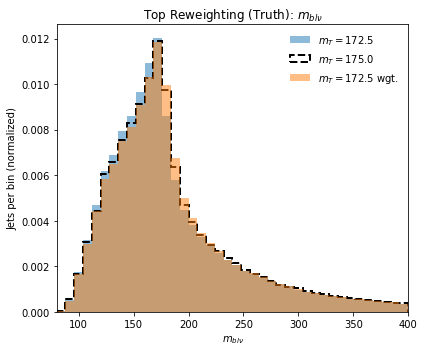

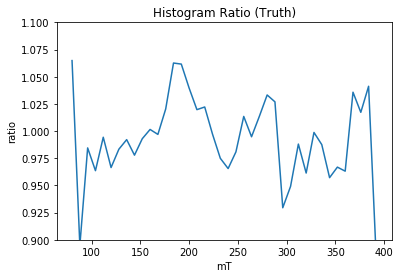

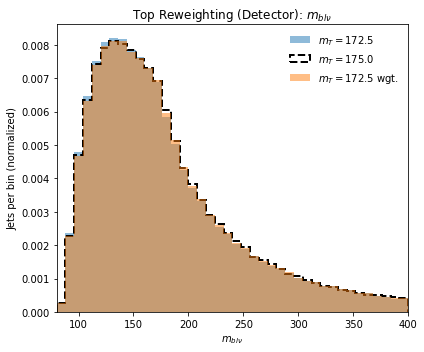

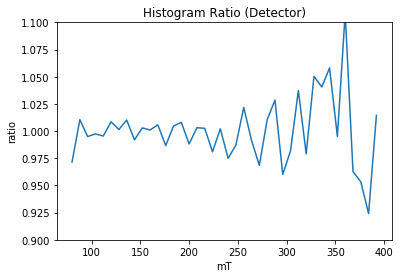

Truth Cor  0.9994496803810476
Det Cor  0.999911057163348
theta:  178.5


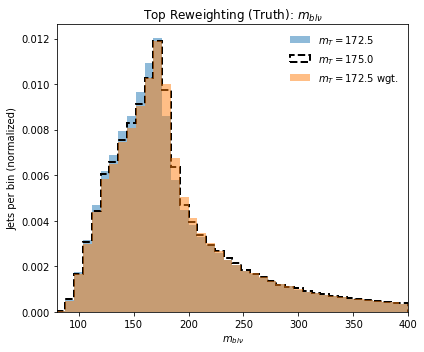

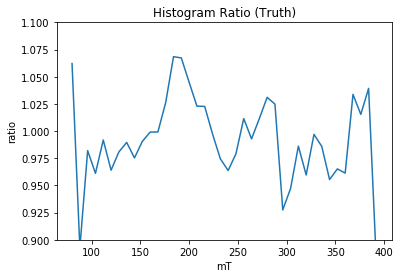

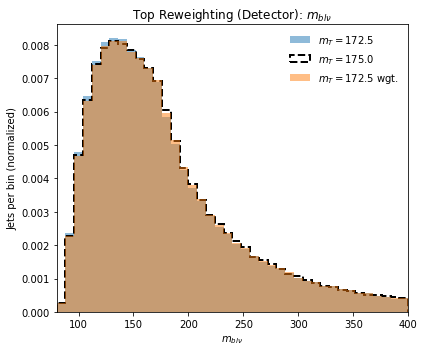

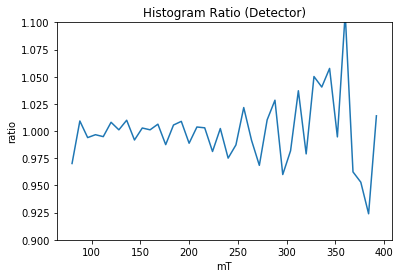

Truth Cor  0.9993194469181197
Det Cor  0.9999115435105266
theta:  179.0


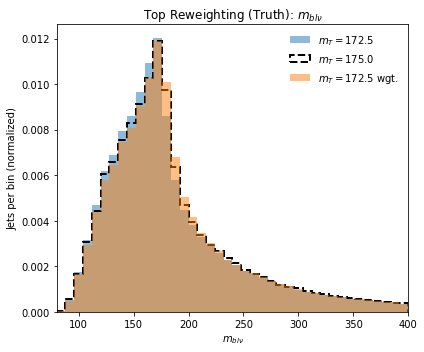

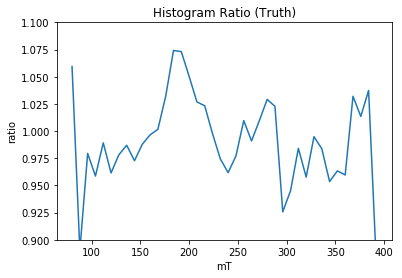

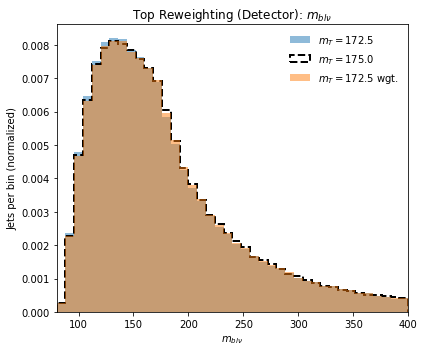

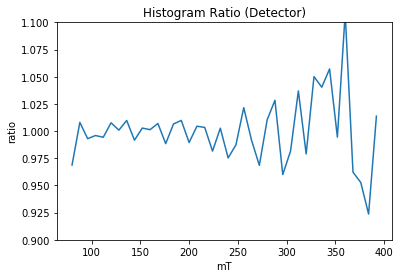

Truth Cor  0.9991664441123802
Det Cor  0.9999113232301853
theta:  179.5


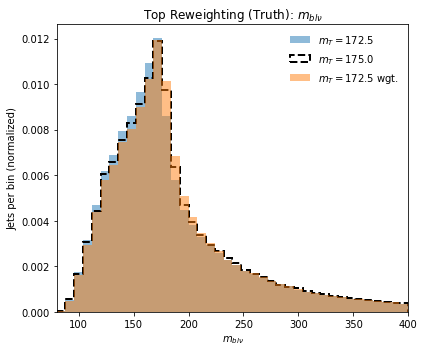

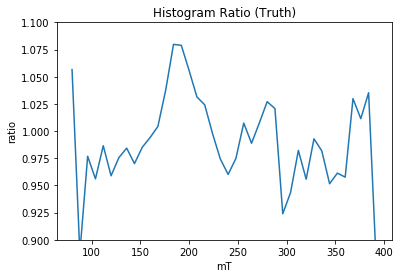

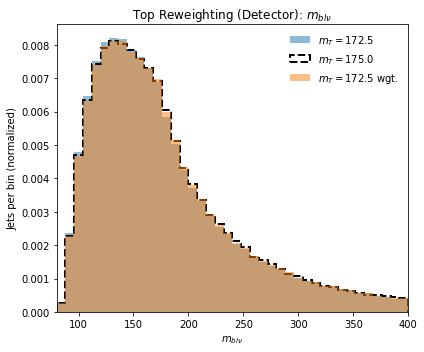

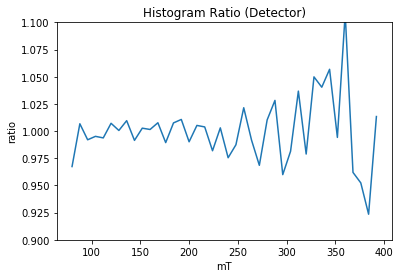

Truth Cor  0.9989912320281944
Det Cor  0.9999103659635685
theta:  180.0


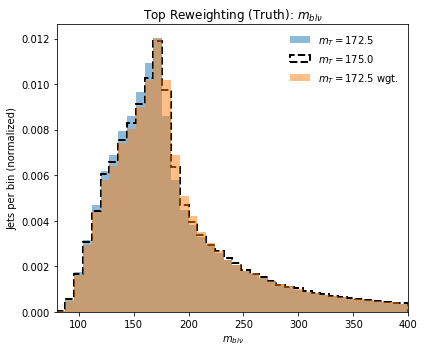

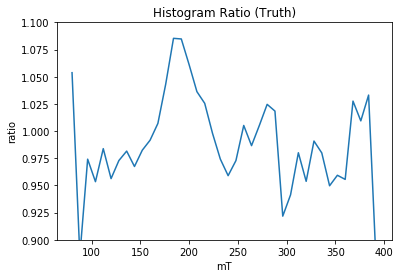

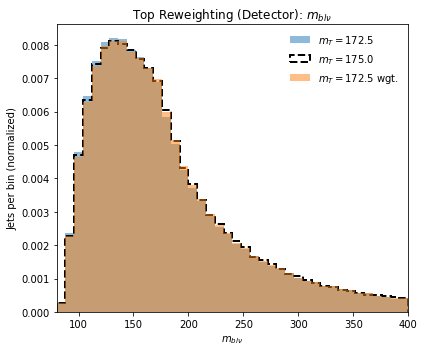

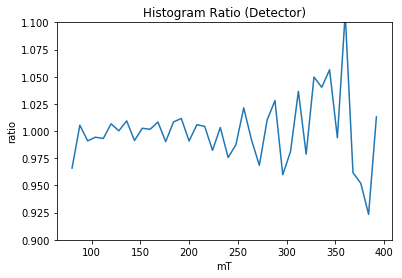

Truth Cor  0.9987936805298542
Det Cor  0.99990881535758


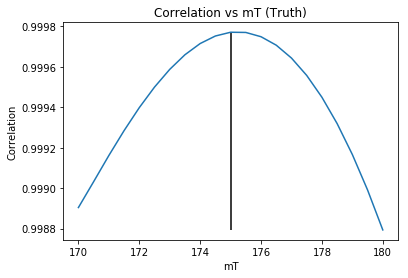

175.0


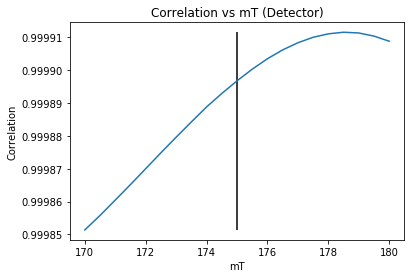

178.5


In [20]:
thetas = np.linspace(170, 180, 21)
cor_total = []
cor_det_total = []
for i in range(len(dctr_weights)):
    print("Weight Iteration: ", i)
    K.clear_session()
    # DCTR architecture 
    inputs = Input((3, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy', optimizer='Adam')
    
    dctr.set_weights(dctr_weights[i])
    
    cor = []
    cor_det = []
    weights_thetas = []

    # weights[6] weird

    for theta in thetas:
        print("theta: ", theta)
        weights = reweight(default_dataset=tf.convert_to_tensor(
        preprocess(test_dataset_0), dtype=tf.float32),
                         mT=preprocess_mT(theta))

        weights = K.eval(weights)

        weights_thetas += [weights]

        bins = np.linspace(80, 400, 41)
        plt.figure(figsize=(6, 5))
        plt.title(r"Top Reweighting (Truth): $m_{bl\nu}$")
        bins = np.linspace(80, 400, 41)
        hist0_mlbv = plt.hist(test_dataset_0_obs,
                            bins=bins,
                            label=label_0,
                            **plot_style_1)
        hist1_mlbv = plt.hist(test_dataset_1_obs,
                            bins=bins,
                            label=label_1,
                            **plot_style_0)
        hist2_mlbv = plt.hist(test_dataset_0_obs,
                            bins=bins,
                            label=label_0 + ' wgt.',
                            weights=weights,
                            **plot_style_1)

        plt.xlabel(r'$m_{bl\nu}$')
        plt.ylabel('Jets per bin (normalized)')
        plt.xlim([80, 400])
        make_legend()
        plt.show()

        ratio = hist2_mlbv[0]/hist1_mlbv[0]

        plt.figure()
        plt.title("Histogram Ratio (Truth)")
        plt.plot(hist2_mlbv[1][:40], ratio)
        plt.xlabel("mT")
        plt.ylabel("ratio")
        plt.ylim([0.9, 1.1])
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.title(r"Top Reweighting (Detector): $m_{bl\nu}$")
        bins = np.linspace(80, 400, 41)
        hist0_mlbv_det = plt.hist(test_dataset_0_obs_det[:, 0],
                              bins=bins,
                              label=label_0,
                              **plot_style_1)
        hist1_mlbv_det = plt.hist(test_dataset_1_obs_det[:, 0],
                              bins=bins,
                              label=label_1,
                              **plot_style_0)
        hist2_mlbv_det = plt.hist(test_dataset_0_obs_det[:, 0],
                              bins=bins,
                              label=label_0 + ' wgt.',
                              weights=weights,
                              **plot_style_1)
        plt.xlabel(r'$m_{bl\nu}$')
        plt.ylabel('Jets per bin (normalized)')
        plt.xlim([80, 400])
        make_legend()
        plt.show()

        ratio_det = hist2_mlbv_det[0]/hist1_mlbv_det[0]

        plt.figure()
        plt.title("Histogram Ratio (Detector)")
        plt.plot(hist2_mlbv_det[1][:40], ratio_det)
        plt.xlabel("mT")
        plt.ylabel("ratio")
        plt.ylim([0.9, 1.1])
        plt.show()


        correlation = cv2.compareHist(plt_hist_to_cv(hist1_mlbv),
                              plt_hist_to_cv(hist2_mlbv),
                              method=0)
        cor += [correlation]
        print("Truth Cor ", correlation)

        correlation = cv2.compareHist(plt_hist_to_cv(hist1_mlbv_det),
                                  plt_hist_to_cv(hist2_mlbv_det),
                                  method=0)
        cor_det += [correlation]
        print("Det Cor ", correlation)
        
    cor_total += [cor]
    cor_det_total += [cor_det]
        
    plt.title("Correlation vs mT (Truth)")
    plt.xlabel("mT")
    plt.ylabel("Correlation")
    plt.plot(thetas, cor)
    plt.vlines(175, min(cor), max(cor), label = 'Truth')
    plt.legend
    plt.show()

    print(thetas[np.argmax(cor)])
    
    plt.title("Correlation vs mT (Detector)")
    plt.xlabel("mT")
    plt.ylabel("Correlation")
    plt.plot(thetas, cor_det)
    plt.vlines(175, min(cor_det), max(cor_det), label = 'Truth')
    plt.legend
    plt.show()

    print(thetas[np.argmax(cor_det)])

Weight Iteration:  0


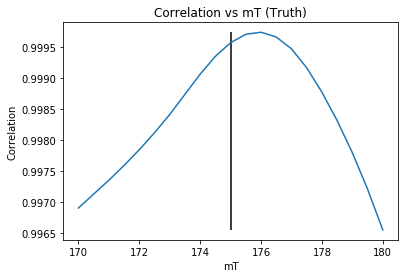

Truth Max:  176.0


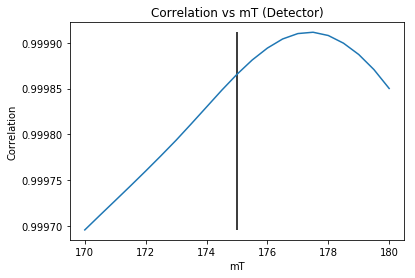

Detector Max:  177.5


Weight Iteration:  1


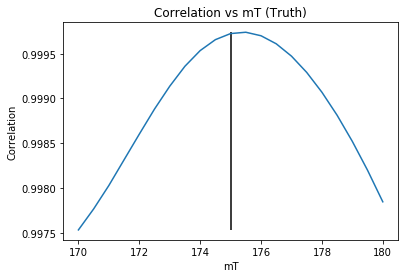

Truth Max:  175.5


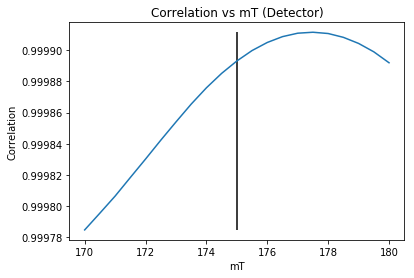

Detector Max:  177.5


Weight Iteration:  2


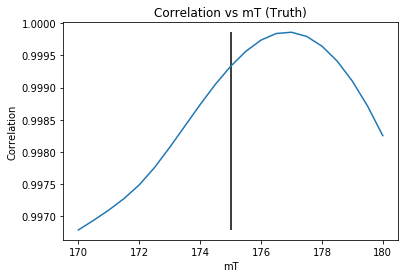

Truth Max:  177.0


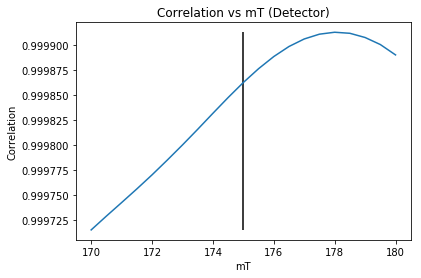

Detector Max:  178.0


Weight Iteration:  3


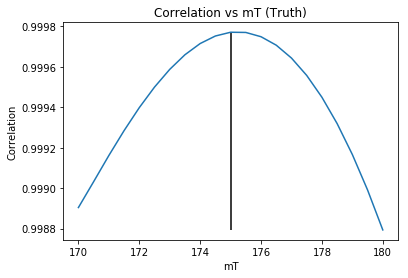

Truth Max:  175.0


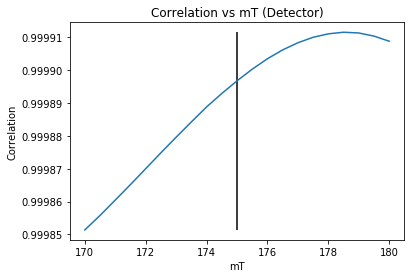

Detector Max:  178.5




In [21]:
for i in range(len(dctr_weights)):
    print("Weight Iteration: ", i)
    
    plt.title("Correlation vs mT (Truth)")
    plt.xlabel("mT")
    plt.ylabel("Correlation")
    plt.plot(thetas, cor_total[i])
    plt.vlines(175, min(cor_total[i]), max(cor_total[i]), label = 'Truth')
    plt.legend
    plt.show()

    print("Truth Max: ", thetas[np.argmax(cor_total[i])])
    
    plt.title("Correlation vs mT (Detector)")
    plt.xlabel("mT")
    plt.ylabel("Correlation")
    plt.plot(thetas, cor_det_total[i])
    plt.vlines(175, min(cor_det_total[i]), max(cor_det_total[i]), label = 'Truth')
    plt.legend
    plt.show()

    print("Detector Max: ", thetas[np.argmax(cor_det_total[i])])
    print("\n")